In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [3]:
from utils import plot_confusion_matrix
from dataset import read_dataset, prepare_dataset
from models import RNNModel, ComplexRNNModel
from constants import BASIC_TRAINING_COLS, FORCE_CLASS_COLS, MASS_CLASS_COLS
from training import evaluate, training_loop

# MASS TRAINING (max so far 52%)

## Read dataset and preprocess it

In [37]:
all_trials = read_dataset("passive_trials.h5")
train_loader, val_loader, scaler = prepare_dataset(all_trials, MASS_CLASS_COLS, normalise_data=True, 
                                                   batch_size=128, test_size=0.3, equiprobable_training_classes=True)

In [38]:
Y = []
for x,y in train_loader:
    
    Y.extend(list(y))

counts = np.unique(Y, return_counts=True)[1]

In [39]:
counts

array([144, 144, 144])

In [40]:
print("Majority class: ", np.max(counts) / np.sum(counts))

Majority class:  0.3333333333333333


## Define model, loss and optimizer

In [41]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

input_dim = len(BASIC_TRAINING_COLS)    # input dimension
first_hidden_dim = 12  # hidden layer dimension
second_hidden_dim = 6     # number of hidden layers
output_dim = 3   # output dimension

model = ComplexRNNModel(input_dim, first_hidden_dim, second_hidden_dim, output_dim)
model = model.cuda()

error = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train model and plot loss and accuracy

In [ ]:
epoch_losses, epoch_accuracies = training_loop(model, optimizer, error, train_loader, val_loader, num_epochs=400)

  0%|          | 1/400 [00:00<05:01,  1.33it/s]

1.1015996932983398 33.7962962962963 23.91304347826087


  0%|          | 2/400 [00:01<04:52,  1.36it/s]

1.0990901291370392 33.101851851851855 25.0


  1%|          | 3/400 [00:02<04:52,  1.36it/s]

1.0985386967658997 34.02777777777778 25.543478260869566


  1%|          | 4/400 [00:03<05:02,  1.31it/s]

1.097508192062378 34.49074074074074 26.902173913043477


  1%|▏         | 5/400 [00:03<05:01,  1.31it/s]

1.0961609780788422 35.416666666666664 28.804347826086957


  2%|▏         | 6/400 [00:04<04:56,  1.33it/s]

1.094732403755188 35.648148148148145 31.793478260869566


  2%|▏         | 7/400 [00:05<04:53,  1.34it/s]

1.0933992266654968 35.416666666666664 32.33695652173913


  2%|▏         | 8/400 [00:06<04:58,  1.31it/s]

1.0935320258140564 36.80555555555556 34.78260869565217


  2%|▏         | 9/400 [00:06<04:47,  1.36it/s]

1.092320442199707 38.657407407407405 36.68478260869565


  2%|▎         | 10/400 [00:07<04:35,  1.41it/s]

1.0914068818092346 38.888888888888886 37.77173913043478


  3%|▎         | 11/400 [00:07<04:28,  1.45it/s]

1.0903725326061249 40.74074074074074 38.31521739130435


  3%|▎         | 12/400 [00:08<04:24,  1.47it/s]

1.0899098813533783 40.27777777777778 39.67391304347826


  3%|▎         | 13/400 [00:09<04:23,  1.47it/s]

1.0881576836109161 41.2037037037037 43.47826086956522


  4%|▎         | 14/400 [00:10<04:33,  1.41it/s]

1.0876241624355316 42.129629629629626 45.65217391304348


  4%|▍         | 15/400 [00:10<04:47,  1.34it/s]

1.0864095091819763 42.129629629629626 46.46739130434783


  4%|▍         | 16/400 [00:11<05:00,  1.28it/s]

1.0850942730903625 42.361111111111114 47.55434782608695


  4%|▍         | 17/400 [00:12<05:08,  1.24it/s]

1.0826814770698547 43.75 48.369565217391305


  4%|▍         | 18/400 [00:13<05:11,  1.22it/s]

1.0819644629955292 43.51851851851852 48.369565217391305


  5%|▍         | 19/400 [00:14<05:15,  1.21it/s]

1.0781303346157074 43.28703703703704 50.54347826086956


  5%|▌         | 20/400 [00:15<05:10,  1.22it/s]

1.0777659118175507 43.98148148148148 51.630434782608695


  5%|▌         | 21/400 [00:15<04:43,  1.34it/s]

1.075715810060501 44.21296296296296 52.71739130434783


  6%|▌         | 22/400 [00:16<04:23,  1.43it/s]

1.0747893750667572 43.28703703703704 53.53260869565217


  6%|▌         | 23/400 [00:17<04:32,  1.39it/s]

1.070994108915329 43.28703703703704 53.53260869565217


  6%|▌         | 24/400 [00:17<04:26,  1.41it/s]

1.069027304649353 42.824074074074076 53.80434782608695


  6%|▋         | 25/400 [00:18<04:19,  1.44it/s]

1.0659604370594025 43.51851851851852 54.07608695652174


  6%|▋         | 26/400 [00:19<04:17,  1.45it/s]

1.0639709681272507 43.75 54.619565217391305


  7%|▋         | 27/400 [00:19<04:11,  1.49it/s]

1.0598616153001785 43.28703703703704 54.619565217391305


  7%|▋         | 28/400 [00:20<04:10,  1.48it/s]

1.0596752613782883 43.51851851851852 54.34782608695652


  7%|▋         | 29/400 [00:21<04:30,  1.37it/s]

1.0559138059616089 43.28703703703704 54.619565217391305


  8%|▊         | 30/400 [00:22<04:46,  1.29it/s]

1.0520517379045486 43.28703703703704 54.07608695652174


  8%|▊         | 31/400 [00:22<04:26,  1.38it/s]

1.0504901260137558 43.51851851851852 53.80434782608695


  8%|▊         | 32/400 [00:23<04:22,  1.40it/s]

1.0460462719202042 43.51851851851852 53.26086956521739


  8%|▊         | 33/400 [00:24<04:31,  1.35it/s]

1.043128177523613 43.98148148148148 53.80434782608695


  8%|▊         | 34/400 [00:25<04:39,  1.31it/s]

1.0388580858707428 44.675925925925924 54.619565217391305


  9%|▉         | 35/400 [00:25<04:51,  1.25it/s]

1.0364380925893784 44.21296296296296 54.619565217391305


  9%|▉         | 36/400 [00:26<04:33,  1.33it/s]

1.0325206220149994 45.138888888888886 54.619565217391305


  9%|▉         | 37/400 [00:27<04:17,  1.41it/s]

1.0294664204120636 44.907407407407405 54.891304347826086


 10%|▉         | 38/400 [00:27<04:06,  1.47it/s]

1.026112213730812 45.370370370370374 54.619565217391305


 10%|▉         | 39/400 [00:28<04:01,  1.49it/s]

1.0217559188604355 46.2962962962963 54.891304347826086


 10%|█         | 40/400 [00:29<03:59,  1.50it/s]

1.016344502568245 46.52777777777778 55.16304347826087


 10%|█         | 41/400 [00:29<03:57,  1.51it/s]

1.011131376028061 46.75925925925926 54.891304347826086


 10%|█         | 42/400 [00:30<04:12,  1.42it/s]

1.0065898597240448 47.68518518518518 54.07608695652174


 11%|█         | 43/400 [00:31<04:07,  1.44it/s]

1.001694068312645 48.379629629629626 53.53260869565217


 11%|█         | 44/400 [00:31<04:01,  1.47it/s]

0.9983195513486862 48.379629629629626 53.26086956521739


 11%|█▏        | 45/400 [00:32<03:56,  1.50it/s]

0.9881610423326492 48.611111111111114 52.98913043478261


 12%|█▏        | 46/400 [00:33<03:55,  1.50it/s]

0.9849268049001694 49.53703703703704 52.98913043478261


 12%|█▏        | 47/400 [00:33<03:52,  1.52it/s]

0.9767539948225021 49.53703703703704 52.44565217391305


 12%|█▏        | 48/400 [00:34<03:51,  1.52it/s]

0.9696420878171921 50.23148148148148 52.17391304347826


 12%|█▏        | 49/400 [00:35<03:51,  1.52it/s]

0.9667656421661377 51.620370370370374 52.44565217391305


 12%|█▎        | 50/400 [00:35<03:47,  1.54it/s]

0.9595265239477158 52.31481481481482 50.81521739130435


 13%|█▎        | 51/400 [00:36<03:48,  1.53it/s]

0.9564420729875565 53.24074074074074 51.630434782608695


 13%|█▎        | 52/400 [00:37<04:06,  1.41it/s]

0.9445011615753174 53.47222222222222 51.08695652173913


 13%|█▎        | 53/400 [00:38<04:21,  1.33it/s]

0.9389075189828873 53.7037037037037 50.27173913043478


 14%|█▎        | 54/400 [00:39<04:32,  1.27it/s]

0.9372133910655975 54.398148148148145 50.81521739130435


 14%|█▍        | 55/400 [00:39<04:24,  1.31it/s]

0.9280373603105545 55.324074074074076 52.17391304347826


 14%|█▍        | 56/400 [00:40<04:12,  1.36it/s]

0.9243811368942261 56.25 51.358695652173914


 14%|█▍        | 57/400 [00:41<04:04,  1.40it/s]

0.9204279184341431 56.25 51.358695652173914


 14%|█▍        | 58/400 [00:41<03:59,  1.43it/s]

0.9151624888181686 56.71296296296296 51.358695652173914


 15%|█▍        | 59/400 [00:42<03:58,  1.43it/s]

0.9087180197238922 56.94444444444444 51.08695652173913


 15%|█▌        | 60/400 [00:43<03:54,  1.45it/s]

0.8987327963113785 57.407407407407405 51.08695652173913


 15%|█▌        | 61/400 [00:43<03:54,  1.45it/s]

0.8961226791143417 57.870370370370374 51.08695652173913


 16%|█▌        | 62/400 [00:44<04:02,  1.39it/s]

0.8874004185199738 57.870370370370374 50.81521739130435


 16%|█▌        | 63/400 [00:45<04:08,  1.35it/s]

0.8849169015884399 58.101851851851855 50.81521739130435


 16%|█▌        | 64/400 [00:46<04:00,  1.40it/s]

0.8782031089067459 58.7962962962963 51.358695652173914


 16%|█▋        | 65/400 [00:46<03:53,  1.44it/s]

0.8737669438123703 59.25925925925926 51.358695652173914


 16%|█▋        | 66/400 [00:47<03:48,  1.46it/s]

0.8631844818592072 59.72222222222222 51.358695652173914


 17%|█▋        | 67/400 [00:48<04:00,  1.39it/s]

0.8576173186302185 59.9537037037037 50.27173913043478


 17%|█▋        | 68/400 [00:48<04:06,  1.34it/s]

0.8563997894525528 59.9537037037037 51.08695652173913


 17%|█▋        | 69/400 [00:49<03:55,  1.41it/s]

0.8480114340782166 59.9537037037037 50.27173913043478


 18%|█▊        | 70/400 [00:50<03:49,  1.44it/s]

0.8382134884595871 61.111111111111114 50.27173913043478


 18%|█▊        | 71/400 [00:50<03:42,  1.48it/s]

0.8422747999429703 62.5 49.45652173913044


 18%|█▊        | 72/400 [00:51<03:37,  1.51it/s]

0.8306381851434708 62.5 49.72826086956522


 18%|█▊        | 73/400 [00:52<03:33,  1.53it/s]

0.8224521577358246 62.96296296296296 49.45652173913044


 18%|█▊        | 74/400 [00:52<03:31,  1.54it/s]

0.8181037604808807 63.657407407407405 50.0


 19%|█▉        | 75/400 [00:53<03:29,  1.55it/s]

0.81355419754982 64.81481481481481 50.27173913043478


 19%|█▉        | 76/400 [00:54<03:27,  1.56it/s]

0.8122050166130066 65.04629629629629 50.81521739130435


 19%|█▉        | 77/400 [00:54<03:25,  1.57it/s]

0.8025580048561096 65.27777777777777 50.81521739130435


 20%|█▉        | 78/400 [00:55<03:25,  1.56it/s]

0.7955029308795929 65.50925925925925 50.54347826086956


 20%|█▉        | 79/400 [00:55<03:30,  1.53it/s]

0.7924510687589645 65.04629629629629 50.27173913043478


 20%|██        | 80/400 [00:56<03:49,  1.39it/s]

0.7870165333151817 65.74074074074075 50.27173913043478


 20%|██        | 81/400 [00:57<03:58,  1.34it/s]

0.7923189848661423 65.74074074074075 50.27173913043478


 20%|██        | 82/400 [00:58<03:50,  1.38it/s]

0.7823953926563263 66.20370370370371 51.90217391304348


 21%|██        | 83/400 [00:58<03:39,  1.45it/s]

0.7687107101082802 66.20370370370371 52.17391304347826


 21%|██        | 84/400 [00:59<03:31,  1.50it/s]

0.7706698998808861 66.43518518518519 52.17391304347826


 21%|██▏       | 85/400 [01:00<03:23,  1.55it/s]

0.7642030492424965 67.36111111111111 52.17391304347826


 22%|██▏       | 86/400 [01:00<03:22,  1.55it/s]

0.7578180730342865 67.12962962962963 51.358695652173914


 22%|██▏       | 87/400 [01:01<03:38,  1.43it/s]

0.7617428451776505 67.5925925925926 50.54347826086956


 22%|██▏       | 88/400 [01:02<03:37,  1.43it/s]

0.762546494603157 68.05555555555556 50.81521739130435


 22%|██▏       | 89/400 [01:02<03:33,  1.46it/s]

0.7470856606960297 69.67592592592592 51.358695652173914


 22%|██▎       | 90/400 [01:03<03:27,  1.49it/s]

0.7317601963877678 70.60185185185185 53.26086956521739


 23%|██▎       | 91/400 [01:04<03:27,  1.49it/s]

0.7276487126946449 70.83333333333333 53.53260869565217


 23%|██▎       | 92/400 [01:04<03:25,  1.50it/s]

0.739144079387188 69.44444444444444 55.16304347826087


 23%|██▎       | 93/400 [01:05<03:34,  1.43it/s]

0.7515593990683556 67.12962962962963 54.34782608695652


 24%|██▎       | 94/400 [01:06<03:40,  1.38it/s]

0.7503010854125023 68.05555555555556 54.34782608695652


 24%|██▍       | 95/400 [01:07<03:39,  1.39it/s]

0.7643114775419235 69.21296296296296 55.16304347826087


 24%|██▍       | 96/400 [01:07<03:37,  1.40it/s]

0.7449383065104485 69.9074074074074 55.43478260869565


 24%|██▍       | 97/400 [01:08<03:33,  1.42it/s]

0.7431828901171684 70.13888888888889 55.43478260869565


 24%|██▍       | 98/400 [01:09<03:25,  1.47it/s]

0.7392288967967033 70.60185185185185 55.70652173913044


 25%|██▍       | 99/400 [01:09<03:19,  1.51it/s]

0.7326836064457893 70.83333333333333 55.70652173913044


 25%|██▌       | 100/400 [01:10<03:17,  1.52it/s]

0.7190942317247391 71.29629629629629 56.25


 25%|██▌       | 101/400 [01:11<03:13,  1.54it/s]

0.7150084748864174 71.29629629629629 55.97826086956522


 26%|██▌       | 102/400 [01:11<03:11,  1.56it/s]

0.7143992930650711 70.83333333333333 56.52173913043478


 26%|██▌       | 103/400 [01:12<03:09,  1.57it/s]

0.7074823901057243 70.60185185185185 56.52173913043478


 26%|██▌       | 104/400 [01:13<03:10,  1.56it/s]

0.710317499935627 70.60185185185185 56.25


 26%|██▋       | 105/400 [01:13<03:10,  1.55it/s]

0.7026296108961105 71.99074074074075 56.25


 26%|██▋       | 106/400 [01:14<03:25,  1.43it/s]

0.707452617585659 72.45370370370371 56.52173913043478


 27%|██▋       | 107/400 [01:15<03:28,  1.41it/s]

0.6941336914896965 72.91666666666667 56.52173913043478


 27%|██▋       | 108/400 [01:15<03:23,  1.43it/s]

0.6997779160737991 73.61111111111111 56.79347826086956


 27%|██▋       | 109/400 [01:16<03:18,  1.46it/s]

0.6955119296908379 73.8425925925926 55.97826086956522


 28%|██▊       | 110/400 [01:17<03:23,  1.43it/s]

0.6935242637991905 73.8425925925926 55.70652173913044


 28%|██▊       | 111/400 [01:18<03:33,  1.35it/s]

0.6883855313062668 73.8425925925926 55.70652173913044


 28%|██▊       | 112/400 [01:18<03:26,  1.39it/s]

0.6887095645070076 73.8425925925926 55.43478260869565


 28%|██▊       | 113/400 [01:19<03:31,  1.36it/s]

0.6788074672222137 73.37962962962963 55.43478260869565


 28%|██▊       | 114/400 [01:20<03:34,  1.33it/s]

0.6757241412997246 73.61111111111111 55.43478260869565


 29%|██▉       | 115/400 [01:21<03:36,  1.32it/s]

0.67630834877491 73.61111111111111 55.43478260869565


 29%|██▉       | 116/400 [01:21<03:31,  1.34it/s]

0.6668895557522774 73.61111111111111 54.891304347826086


 29%|██▉       | 117/400 [01:22<03:34,  1.32it/s]

0.6639520600438118 74.30555555555556 54.891304347826086


 30%|██▉       | 118/400 [01:23<03:20,  1.40it/s]

0.6682961657643318 75.0 54.619565217391305


 30%|██▉       | 119/400 [01:23<03:12,  1.46it/s]

0.6643755733966827 75.46296296296296 54.891304347826086


 30%|███       | 120/400 [01:24<03:10,  1.47it/s]

0.6656812354922295 75.46296296296296 54.891304347826086


 30%|███       | 121/400 [01:25<03:25,  1.36it/s]

0.6468308940529823 75.46296296296296 54.891304347826086


 30%|███       | 122/400 [01:26<03:36,  1.29it/s]

0.6606173813343048 75.69444444444444 54.891304347826086


 31%|███       | 123/400 [01:27<03:36,  1.28it/s]

0.6614024192094803 75.23148148148148 54.891304347826086


 31%|███       | 124/400 [01:27<03:23,  1.36it/s]

0.6570698022842407 75.23148148148148 55.16304347826087


 31%|███▏      | 125/400 [01:28<03:12,  1.43it/s]

0.6516030356287956 75.69444444444444 55.43478260869565


 32%|███▏      | 126/400 [01:28<03:04,  1.48it/s]

0.6395224705338478 75.69444444444444 55.43478260869565


 32%|███▏      | 127/400 [01:29<03:09,  1.44it/s]

0.6369253695011139 75.46296296296296 54.619565217391305


 32%|███▏      | 128/400 [01:30<03:18,  1.37it/s]

0.6373036950826645 75.69444444444444 54.619565217391305


 32%|███▏      | 129/400 [01:31<03:09,  1.43it/s]

0.6328590139746666 76.1574074074074 54.619565217391305


 32%|███▎      | 130/400 [01:31<03:02,  1.48it/s]

0.6311035826802254 76.1574074074074 54.619565217391305


 33%|███▎      | 131/400 [01:32<02:56,  1.52it/s]

0.6323128864169121 76.38888888888889 54.619565217391305


 33%|███▎      | 132/400 [01:33<02:57,  1.51it/s]

0.6357535049319267 76.85185185185185 54.619565217391305


 33%|███▎      | 133/400 [01:33<03:12,  1.39it/s]

0.6163398772478104 77.31481481481481 54.34782608695652


 34%|███▎      | 134/400 [01:34<03:24,  1.30it/s]

0.6255026832222939 76.62037037037037 54.891304347826086


 34%|███▍      | 135/400 [01:35<03:23,  1.30it/s]

0.6199698075652122 76.62037037037037 54.891304347826086


 34%|███▍      | 136/400 [01:36<03:22,  1.30it/s]

0.6187294647097588 76.62037037037037 54.619565217391305


 34%|███▍      | 137/400 [01:37<03:20,  1.31it/s]

0.6104767695069313 76.38888888888889 54.891304347826086


 34%|███▍      | 138/400 [01:37<03:14,  1.35it/s]

0.6156393066048622 77.08333333333333 54.07608695652174


 35%|███▍      | 139/400 [01:38<03:15,  1.34it/s]

0.6124189719557762 76.85185185185185 54.07608695652174


 35%|███▌      | 140/400 [01:39<03:04,  1.41it/s]

0.6047413870692253 77.31481481481481 54.07608695652174


 35%|███▌      | 141/400 [01:39<03:05,  1.40it/s]

0.6059835255146027 77.54629629629629 54.34782608695652


 36%|███▌      | 142/400 [01:40<02:55,  1.47it/s]

0.6055542230606079 77.31481481481481 54.34782608695652


 36%|███▌      | 143/400 [01:41<02:53,  1.48it/s]

0.6051044389605522 77.31481481481481 54.619565217391305


 36%|███▌      | 144/400 [01:41<03:03,  1.39it/s]

0.6067736148834229 77.77777777777777 54.34782608695652


 36%|███▋      | 145/400 [01:42<03:03,  1.39it/s]

0.6072843000292778 77.31481481481481 53.53260869565217


 36%|███▋      | 146/400 [01:43<02:58,  1.42it/s]

0.5941834226250648 77.54629629629629 53.53260869565217


 37%|███▋      | 147/400 [01:43<02:51,  1.48it/s]

0.6013698428869247 77.54629629629629 53.53260869565217


 37%|███▋      | 148/400 [01:44<02:45,  1.52it/s]

0.5964020192623138 76.85185185185185 54.34782608695652


 37%|███▋      | 149/400 [01:45<02:41,  1.55it/s]

0.6001344248652458 77.08333333333333 55.16304347826087


 38%|███▊      | 150/400 [01:45<02:38,  1.57it/s]

0.5894665122032166 76.85185185185185 54.891304347826086


 38%|███▊      | 151/400 [01:46<02:36,  1.59it/s]

0.5968834087252617 76.38888888888889 54.34782608695652


 38%|███▊      | 152/400 [01:47<02:35,  1.59it/s]

0.6012968793511391 77.08333333333333 54.07608695652174


 38%|███▊      | 153/400 [01:47<02:47,  1.47it/s]

0.5896459594368935 77.54629629629629 54.619565217391305


 38%|███▊      | 154/400 [01:48<02:45,  1.49it/s]

0.5857471078634262 76.85185185185185 54.891304347826086


 39%|███▉      | 155/400 [01:49<02:42,  1.51it/s]

0.6004779487848282 76.62037037037037 54.619565217391305


 39%|███▉      | 156/400 [01:49<02:37,  1.55it/s]

0.5907042250037193 76.62037037037037 54.34782608695652


 39%|███▉      | 157/400 [01:50<02:41,  1.50it/s]

0.603089727461338 76.62037037037037 54.34782608695652


 40%|███▉      | 158/400 [01:51<02:43,  1.48it/s]

0.5988790169358253 76.1574074074074 53.53260869565217


 40%|███▉      | 159/400 [01:51<02:47,  1.44it/s]

0.581604890525341 76.38888888888889 53.80434782608695


 40%|████      | 160/400 [01:52<02:58,  1.35it/s]

0.5893067196011543 76.62037037037037 52.98913043478261


 40%|████      | 161/400 [01:53<03:07,  1.28it/s]

0.576085165143013 77.54629629629629 53.53260869565217


 40%|████      | 162/400 [01:54<03:11,  1.25it/s]

0.5872830525040627 77.54629629629629 53.80434782608695


 41%|████      | 163/400 [01:55<03:14,  1.22it/s]

0.570379950106144 77.54629629629629 53.80434782608695


 41%|████      | 164/400 [01:56<03:13,  1.22it/s]

0.5832999795675278 77.54629629629629 53.53260869565217


 41%|████▏     | 165/400 [01:56<03:15,  1.20it/s]

0.5773327872157097 77.54629629629629 52.98913043478261


 42%|████▏     | 166/400 [01:57<03:15,  1.20it/s]

0.5786383748054504 77.54629629629629 52.98913043478261


 42%|████▏     | 167/400 [01:58<03:16,  1.19it/s]

0.5718895420432091 77.54629629629629 52.98913043478261


 42%|████▏     | 168/400 [01:59<03:16,  1.18it/s]

0.5683954432606697 78.00925925925925 52.71739130434783


 42%|████▏     | 169/400 [02:00<03:17,  1.17it/s]

0.5630928874015808 77.08333333333333 51.630434782608695


 42%|████▎     | 170/400 [02:01<03:18,  1.16it/s]

0.5865070447325706 77.08333333333333 51.358695652173914


 43%|████▎     | 171/400 [02:02<03:17,  1.16it/s]

0.5848542600870132 77.31481481481481 51.358695652173914


 43%|████▎     | 172/400 [02:03<03:15,  1.17it/s]

0.5868090242147446 77.54629629629629 51.90217391304348


 43%|████▎     | 173/400 [02:03<03:05,  1.22it/s]

0.5804994404315948 78.24074074074075 52.17391304347826


 44%|████▎     | 174/400 [02:04<03:04,  1.22it/s]

0.569314993917942 78.00925925925925 52.17391304347826


 44%|████▍     | 175/400 [02:05<02:53,  1.29it/s]

0.5580897852778435 78.47222222222223 52.17391304347826


 44%|████▍     | 176/400 [02:05<02:53,  1.29it/s]

0.563660591840744 78.93518518518519 52.44565217391305


 44%|████▍     | 177/400 [02:06<02:46,  1.34it/s]

0.5651737302541733 79.16666666666667 52.44565217391305


 44%|████▍     | 178/400 [02:07<02:47,  1.33it/s]

0.557098776102066 79.39814814814815 52.17391304347826


 45%|████▍     | 179/400 [02:08<02:47,  1.32it/s]

0.5462731495499611 79.62962962962963 51.90217391304348


 45%|████▌     | 180/400 [02:09<02:48,  1.30it/s]

0.5532605871558189 79.39814814814815 51.358695652173914


 45%|████▌     | 181/400 [02:09<02:48,  1.30it/s]

0.5669590383768082 79.16666666666667 51.358695652173914


 46%|████▌     | 182/400 [02:10<02:41,  1.35it/s]

0.5702027529478073 78.93518518518519 51.630434782608695


 46%|████▌     | 183/400 [02:11<02:41,  1.34it/s]

0.5690531134605408 79.39814814814815 51.08695652173913


 46%|████▌     | 184/400 [02:11<02:40,  1.35it/s]

0.5497438460588455 79.16666666666667 51.08695652173913


 46%|████▋     | 185/400 [02:12<02:41,  1.33it/s]

0.55900589376688 79.16666666666667 51.630434782608695


 46%|████▋     | 186/400 [02:13<02:45,  1.29it/s]

0.5427633225917816 79.62962962962963 52.44565217391305


 47%|████▋     | 187/400 [02:14<02:48,  1.26it/s]

0.5635905489325523 79.62962962962963 52.71739130434783


 47%|████▋     | 188/400 [02:15<02:48,  1.26it/s]

0.5494113713502884 79.62962962962963 52.44565217391305


 47%|████▋     | 189/400 [02:16<02:49,  1.24it/s]

0.5595498010516167 79.39814814814815 51.90217391304348


 48%|████▊     | 190/400 [02:16<02:50,  1.23it/s]

0.5543794855475426 79.62962962962963 51.90217391304348


 48%|████▊     | 191/400 [02:17<02:51,  1.22it/s]

0.5426786467432976 79.86111111111111 51.630434782608695


 48%|████▊     | 192/400 [02:18<02:50,  1.22it/s]

0.5442816019058228 79.86111111111111 51.630434782608695


 48%|████▊     | 193/400 [02:19<02:51,  1.21it/s]

0.5385639294981956 79.86111111111111 51.630434782608695


 48%|████▊     | 194/400 [02:20<02:42,  1.27it/s]

0.539304718375206 79.86111111111111 51.630434782608695


 49%|████▉     | 195/400 [02:20<02:35,  1.32it/s]

0.5439426675438881 79.86111111111111 51.630434782608695


 49%|████▉     | 196/400 [02:21<02:30,  1.35it/s]

0.5329518243670464 80.0925925925926 51.630434782608695


 49%|████▉     | 197/400 [02:22<02:32,  1.33it/s]

0.5382220894098282 80.0925925925926 51.90217391304348


 50%|████▉     | 198/400 [02:23<02:35,  1.30it/s]

0.5375331044197083 80.32407407407408 51.358695652173914


 50%|████▉     | 199/400 [02:23<02:29,  1.34it/s]

0.531803272664547 80.32407407407408 50.81521739130435


 50%|█████     | 200/400 [02:24<02:29,  1.33it/s]

0.5305147096514702 80.32407407407408 50.81521739130435


 50%|█████     | 201/400 [02:25<02:34,  1.28it/s]

0.5313820689916611 80.55555555555556 50.81521739130435


 50%|█████     | 202/400 [02:25<02:28,  1.33it/s]

0.5272422209382057 80.78703703703704 50.81521739130435


 51%|█████     | 203/400 [02:26<02:32,  1.29it/s]

0.5234250798821449 80.78703703703704 51.08695652173913


 51%|█████     | 204/400 [02:27<02:31,  1.30it/s]

0.5373874679207802 81.01851851851852 51.08695652173913


 51%|█████▏    | 205/400 [02:28<02:33,  1.27it/s]

0.5281565636396408 81.25 51.630434782608695


 52%|█████▏    | 206/400 [02:29<02:28,  1.31it/s]

0.5290836319327354 81.25 51.630434782608695


 52%|█████▏    | 207/400 [02:29<02:32,  1.27it/s]

0.5165832787752151 81.48148148148148 51.358695652173914


 52%|█████▏    | 208/400 [02:30<02:29,  1.29it/s]

0.5255987718701363 81.71296296296296 52.17391304347826


 52%|█████▏    | 209/400 [02:31<02:30,  1.27it/s]

0.5203723385930061 82.17592592592592 52.17391304347826


 52%|█████▎    | 210/400 [02:32<02:22,  1.33it/s]

0.5143297463655472 82.17592592592592 52.44565217391305


 53%|█████▎    | 211/400 [02:32<02:19,  1.36it/s]

0.5009390786290169 82.87037037037037 52.17391304347826


 53%|█████▎    | 212/400 [02:33<02:13,  1.40it/s]

0.5005772784352303 82.4074074074074 52.44565217391305


 53%|█████▎    | 213/400 [02:34<02:19,  1.34it/s]

0.5008011385798454 82.4074074074074 53.53260869565217


 54%|█████▎    | 214/400 [02:35<02:18,  1.34it/s]

0.5083794072270393 81.25 53.53260869565217


 54%|█████▍    | 215/400 [02:35<02:13,  1.39it/s]

0.5168017745018005 81.48148148148148 51.90217391304348


 54%|█████▍    | 216/400 [02:36<02:17,  1.33it/s]

0.5292438492178917 81.25 51.08695652173913


 54%|█████▍    | 217/400 [02:37<02:19,  1.31it/s]

0.5809827223420143 76.85185185185185 48.09782608695652


 55%|█████▍    | 218/400 [02:38<02:21,  1.28it/s]

0.655857726931572 73.61111111111111 46.73913043478261


 55%|█████▍    | 219/400 [02:38<02:15,  1.34it/s]

0.699448898434639 71.29629629629629 45.92391304347826


 55%|█████▌    | 220/400 [02:39<02:13,  1.35it/s]

0.73593570291996 70.83333333333333 45.380434782608695


 55%|█████▌    | 221/400 [02:40<02:15,  1.32it/s]

0.7096292078495026 71.99074074074075 45.65217391304348


 56%|█████▌    | 222/400 [02:41<02:11,  1.36it/s]

0.7039883583784103 73.37962962962963 46.73913043478261


 56%|█████▌    | 223/400 [02:41<02:09,  1.37it/s]

0.6784389466047287 74.53703703703704 47.82608695652174


 56%|█████▌    | 224/400 [02:42<02:05,  1.40it/s]

0.6673642694950104 75.46296296296296 47.82608695652174


 56%|█████▋    | 225/400 [02:43<02:05,  1.40it/s]

0.65105751901865 75.46296296296296 48.09782608695652


 56%|█████▋    | 226/400 [02:43<02:03,  1.40it/s]

0.6641306057572365 76.1574074074074 48.09782608695652


 57%|█████▋    | 227/400 [02:44<02:01,  1.42it/s]

0.6473906859755516 76.38888888888889 49.18478260869565


 57%|█████▋    | 228/400 [02:45<02:07,  1.35it/s]

0.6192690059542656 77.08333333333333 48.91304347826087


 57%|█████▋    | 229/400 [02:46<02:12,  1.29it/s]

0.5855856016278267 76.38888888888889 49.72826086956522


 57%|█████▊    | 230/400 [02:47<02:10,  1.30it/s]

0.6148875281214714 77.31481481481481 50.54347826086956


 58%|█████▊    | 231/400 [02:47<02:06,  1.34it/s]

0.6116346716880798 77.54629629629629 50.81521739130435


 58%|█████▊    | 232/400 [02:48<02:10,  1.29it/s]

0.6109668761491776 77.54629629629629 50.81521739130435


 58%|█████▊    | 233/400 [02:49<02:04,  1.34it/s]

0.5817624405026436 78.00925925925925 51.08695652173913


 58%|█████▊    | 234/400 [02:49<02:02,  1.35it/s]

0.5961666256189346 77.77777777777777 51.358695652173914


 59%|█████▉    | 235/400 [02:50<02:00,  1.37it/s]

0.5929304137825966 78.70370370370371 51.90217391304348


 59%|█████▉    | 236/400 [02:51<02:02,  1.33it/s]

0.5815924480557442 78.93518518518519 51.90217391304348


 59%|█████▉    | 237/400 [02:52<02:03,  1.32it/s]

0.5809038951992989 78.93518518518519 51.630434782608695


 60%|█████▉    | 238/400 [02:52<01:58,  1.36it/s]

0.5816535949707031 79.16666666666667 51.358695652173914


 60%|█████▉    | 239/400 [02:53<01:57,  1.37it/s]

0.5656304135918617 79.39814814814815 50.54347826086956


 60%|██████    | 240/400 [02:54<01:54,  1.40it/s]

0.5567717030644417 79.39814814814815 50.27173913043478


 60%|██████    | 241/400 [02:55<01:59,  1.33it/s]

0.5658456161618233 79.39814814814815 50.81521739130435


 60%|██████    | 242/400 [02:55<01:55,  1.37it/s]

0.5529186725616455 79.16666666666667 50.0


 61%|██████    | 243/400 [02:56<01:53,  1.39it/s]

0.5543419122695923 79.62962962962963 50.54347826086956


 61%|██████    | 244/400 [02:57<01:51,  1.40it/s]

0.5495586693286896 79.86111111111111 50.27173913043478


 61%|██████▏   | 245/400 [02:57<01:50,  1.40it/s]

0.549106739461422 79.86111111111111 50.54347826086956


 62%|██████▏   | 246/400 [02:58<01:49,  1.40it/s]

0.5371325984597206 79.86111111111111 50.0


 62%|██████▏   | 247/400 [02:59<01:50,  1.38it/s]

0.5411367192864418 80.0925925925926 49.72826086956522


 62%|██████▏   | 248/400 [03:00<01:49,  1.39it/s]

0.544537365436554 80.0925925925926 49.45652173913044


 62%|██████▏   | 249/400 [03:00<01:47,  1.41it/s]

0.5497710555791855 80.0925925925926 49.45652173913044


 62%|██████▎   | 250/400 [03:01<01:45,  1.43it/s]

0.5364054143428802 80.0925925925926 49.18478260869565


 63%|██████▎   | 251/400 [03:02<01:44,  1.43it/s]

0.5357690379023552 80.32407407407408 49.18478260869565


 63%|██████▎   | 252/400 [03:02<01:43,  1.43it/s]

0.5167060419917107 80.32407407407408 49.18478260869565


 63%|██████▎   | 253/400 [03:03<01:49,  1.35it/s]

0.5267358273267746 80.32407407407408 50.0


 64%|██████▎   | 254/400 [03:04<01:46,  1.37it/s]

0.5142939984798431 80.78703703703704 49.72826086956522


 64%|██████▍   | 255/400 [03:05<01:42,  1.41it/s]

0.5255096331238747 80.78703703703704 49.72826086956522


 64%|██████▍   | 256/400 [03:05<01:40,  1.43it/s]

0.5096649378538132 81.01851851851852 49.18478260869565


 64%|██████▍   | 257/400 [03:06<01:41,  1.42it/s]

0.5192735493183136 81.01851851851852 49.72826086956522


 64%|██████▍   | 258/400 [03:07<01:45,  1.34it/s]

0.5126199424266815 81.01851851851852 49.18478260869565


 65%|██████▍   | 259/400 [03:08<01:42,  1.37it/s]

0.509117566049099 81.01851851851852 49.72826086956522


 65%|██████▌   | 260/400 [03:08<01:41,  1.38it/s]

0.512162446975708 80.78703703703704 50.0


 65%|██████▌   | 261/400 [03:09<01:39,  1.40it/s]

0.5201133415102959 81.01851851851852 50.27173913043478


 66%|██████▌   | 262/400 [03:10<01:36,  1.43it/s]

0.5274933651089668 80.78703703703704 51.08695652173913


 66%|██████▌   | 263/400 [03:10<01:35,  1.43it/s]

0.5140671208500862 80.78703703703704 51.358695652173914


 66%|██████▌   | 264/400 [03:11<01:36,  1.41it/s]

0.5162448510527611 80.78703703703704 51.630434782608695


 66%|██████▋   | 265/400 [03:12<01:34,  1.43it/s]

0.5102550014853477 80.55555555555556 51.08695652173913


 66%|██████▋   | 266/400 [03:12<01:32,  1.45it/s]

0.5141901448369026 80.55555555555556 51.08695652173913


 67%|██████▋   | 267/400 [03:13<01:31,  1.46it/s]

0.5060361921787262 80.78703703703704 50.81521739130435


 67%|██████▋   | 268/400 [03:14<01:29,  1.47it/s]

0.49711792171001434 80.78703703703704 50.81521739130435


 67%|██████▋   | 269/400 [03:14<01:28,  1.48it/s]

0.5025597363710403 81.25 50.81521739130435


 68%|██████▊   | 270/400 [03:15<01:27,  1.48it/s]

0.4941015765070915 81.25 51.08695652173913


 68%|██████▊   | 271/400 [03:16<01:26,  1.49it/s]

0.49494053423404694 81.25 51.08695652173913


 68%|██████▊   | 272/400 [03:16<01:26,  1.49it/s]

0.48898935317993164 81.25 50.81521739130435


 68%|██████▊   | 273/400 [03:17<01:25,  1.48it/s]

0.5025943368673325 81.25 51.08695652173913


 68%|██████▊   | 274/400 [03:18<01:25,  1.48it/s]

0.5099964961409569 81.48148148148148 51.08695652173913


 69%|██████▉   | 275/400 [03:18<01:24,  1.49it/s]

0.49420852214097977 81.48148148148148 51.08695652173913


 69%|██████▉   | 276/400 [03:19<01:23,  1.49it/s]

0.4918002188205719 81.71296296296296 51.358695652173914


 69%|██████▉   | 277/400 [03:20<01:23,  1.48it/s]

0.5059814527630806 81.71296296296296 50.81521739130435


 70%|██████▉   | 278/400 [03:20<01:22,  1.47it/s]

0.4921475425362587 82.4074074074074 50.81521739130435


 70%|██████▉   | 279/400 [03:21<01:21,  1.48it/s]

0.4868781492114067 81.94444444444444 50.81521739130435


 70%|███████   | 280/400 [03:22<01:21,  1.47it/s]

0.47996247559785843 82.17592592592592 51.08695652173913


 70%|███████   | 281/400 [03:22<01:20,  1.48it/s]

0.48687834292650223 82.4074074074074 50.81521739130435


 70%|███████   | 282/400 [03:23<01:19,  1.48it/s]

0.4829065427184105 82.4074074074074 51.08695652173913


 71%|███████   | 283/400 [03:24<01:18,  1.48it/s]

0.4825214147567749 82.4074074074074 51.08695652173913


 71%|███████   | 284/400 [03:24<01:17,  1.49it/s]

0.47397781163454056 82.63888888888889 50.81521739130435


 71%|███████▏  | 285/400 [03:25<01:16,  1.50it/s]

0.48385801911354065 83.10185185185185 49.45652173913044


 72%|███████▏  | 286/400 [03:26<01:17,  1.48it/s]

0.4788984879851341 83.33333333333333 49.72826086956522


 72%|███████▏  | 287/400 [03:27<01:16,  1.48it/s]

0.48747696727514267 83.33333333333333 49.72826086956522


 72%|███████▏  | 288/400 [03:27<01:15,  1.49it/s]

0.48875368386507034 83.33333333333333 50.0


 72%|███████▏  | 289/400 [03:28<01:14,  1.49it/s]

0.4707440882921219 83.33333333333333 49.45652173913044


 72%|███████▎  | 290/400 [03:29<01:14,  1.49it/s]

0.4763321578502655 83.33333333333333 49.72826086956522


 73%|███████▎  | 291/400 [03:29<01:13,  1.49it/s]

0.47605548053979874 83.56481481481481 50.0


 73%|███████▎  | 292/400 [03:30<01:12,  1.49it/s]

0.47595861554145813 83.56481481481481 50.0


 73%|███████▎  | 293/400 [03:31<01:12,  1.48it/s]

0.4701077342033386 83.56481481481481 50.0


 74%|███████▎  | 294/400 [03:31<01:11,  1.49it/s]

0.47144274413585663 83.56481481481481 50.0


 74%|███████▍  | 295/400 [03:32<01:10,  1.50it/s]

0.4726969078183174 83.56481481481481 50.54347826086956


 74%|███████▍  | 296/400 [03:33<01:09,  1.50it/s]

0.4748946875333786 83.56481481481481 50.0


 74%|███████▍  | 297/400 [03:33<01:08,  1.49it/s]

0.4722774103283882 83.56481481481481 50.0


 74%|███████▍  | 298/400 [03:34<01:08,  1.49it/s]

0.4678535833954811 83.56481481481481 49.72826086956522


 75%|███████▍  | 299/400 [03:35<01:07,  1.50it/s]

0.46617618203163147 83.56481481481481 48.91304347826087


 75%|███████▌  | 300/400 [03:35<01:07,  1.48it/s]

0.4729057252407074 83.56481481481481 48.641304347826086


 75%|███████▌  | 301/400 [03:36<01:06,  1.48it/s]

0.4744453951716423 83.33333333333333 49.18478260869565


 76%|███████▌  | 302/400 [03:37<01:06,  1.47it/s]

0.47149311006069183 83.33333333333333 49.18478260869565


 76%|███████▌  | 303/400 [03:37<01:05,  1.48it/s]

0.4788331016898155 82.87037037037037 49.18478260869565


 76%|███████▌  | 304/400 [03:38<01:04,  1.48it/s]

0.4960061311721802 79.62962962962963 50.27173913043478


 76%|███████▋  | 305/400 [03:39<01:04,  1.48it/s]

0.5652394518256187 79.16666666666667 51.08695652173913


 76%|███████▋  | 306/400 [03:39<01:03,  1.47it/s]

0.5828749015927315 78.93518518518519 50.0


 77%|███████▋  | 307/400 [03:40<01:02,  1.49it/s]

0.5728912428021431 78.47222222222223 50.27173913043478


 77%|███████▋  | 308/400 [03:41<01:02,  1.48it/s]

0.5888611525297165 79.86111111111111 49.45652173913044


 77%|███████▋  | 309/400 [03:41<01:01,  1.47it/s]

0.5856374725699425 79.62962962962963 49.45652173913044


 78%|███████▊  | 310/400 [03:42<01:01,  1.46it/s]

0.5620516315102577 79.62962962962963 49.72826086956522


 78%|███████▊  | 311/400 [03:43<01:00,  1.47it/s]

0.5631327331066132 80.32407407407408 50.0


 78%|███████▊  | 312/400 [03:43<00:59,  1.47it/s]

0.5738584846258163 80.55555555555556 50.27173913043478


 78%|███████▊  | 313/400 [03:44<00:59,  1.47it/s]

0.5495316125452518 80.55555555555556 50.54347826086956


 78%|███████▊  | 314/400 [03:45<00:58,  1.47it/s]

0.5641562454402447 80.78703703703704 50.27173913043478


 79%|███████▉  | 315/400 [03:45<00:57,  1.47it/s]

0.5431859940290451 80.78703703703704 50.0


 79%|███████▉  | 316/400 [03:46<00:57,  1.47it/s]

0.544281393289566 81.01851851851852 50.0


 79%|███████▉  | 317/400 [03:47<00:56,  1.47it/s]

0.534291435033083 81.94444444444444 50.0


 80%|███████▉  | 318/400 [03:47<00:55,  1.47it/s]

0.5423032380640507 81.94444444444444 50.0


 80%|███████▉  | 319/400 [03:48<00:55,  1.47it/s]

0.5496608167886734 82.17592592592592 50.0


 80%|████████  | 320/400 [03:49<00:54,  1.46it/s]

0.5438015460968018 82.17592592592592 49.72826086956522


 80%|████████  | 321/400 [03:50<00:54,  1.45it/s]

0.5499374121427536 82.4074074074074 49.72826086956522


 80%|████████  | 322/400 [03:50<00:53,  1.46it/s]

0.5398563891649246 82.63888888888889 50.27173913043478


 81%|████████  | 323/400 [03:51<00:52,  1.47it/s]

0.5408883951604366 82.63888888888889 50.81521739130435


 81%|████████  | 324/400 [03:52<00:51,  1.47it/s]

0.5296673029661179 82.63888888888889 51.08695652173913


 81%|████████▏ | 325/400 [03:52<00:51,  1.45it/s]

0.5324673280119896 82.63888888888889 50.54347826086956


 82%|████████▏ | 326/400 [03:53<00:50,  1.46it/s]

0.5442172214388847 82.63888888888889 50.54347826086956


 82%|████████▏ | 327/400 [03:54<00:49,  1.47it/s]

0.5377225950360298 82.63888888888889 50.27173913043478


 82%|████████▏ | 328/400 [03:54<00:48,  1.48it/s]

0.5329888015985489 82.63888888888889 50.27173913043478


 82%|████████▏ | 329/400 [03:55<00:47,  1.48it/s]

0.5326600223779678 82.87037037037037 50.54347826086956


 82%|████████▎ | 330/400 [03:56<00:47,  1.48it/s]

0.5369527116417885 83.10185185185185 49.72826086956522


 83%|████████▎ | 331/400 [03:56<00:46,  1.48it/s]

0.5148418173193932 83.33333333333333 49.72826086956522


 83%|████████▎ | 332/400 [03:57<00:45,  1.49it/s]

0.5199422687292099 83.33333333333333 49.72826086956522


 83%|████████▎ | 333/400 [03:58<00:45,  1.47it/s]

0.5164508782327175 83.33333333333333 50.0


 84%|████████▎ | 334/400 [03:58<00:44,  1.48it/s]

0.5072259120643139 83.33333333333333 50.0


 84%|████████▍ | 335/400 [03:59<00:44,  1.46it/s]

0.5202987045049667 83.33333333333333 49.72826086956522


 84%|████████▍ | 336/400 [04:00<00:43,  1.46it/s]

0.5096539482474327 83.33333333333333 50.54347826086956


 84%|████████▍ | 337/400 [04:00<00:42,  1.47it/s]

0.5093050822615623 83.33333333333333 51.08695652173913


 84%|████████▍ | 338/400 [04:01<00:42,  1.47it/s]

0.523030661046505 83.33333333333333 51.358695652173914


 85%|████████▍ | 339/400 [04:02<00:41,  1.48it/s]

0.49683815985918045 83.33333333333333 50.81521739130435


 85%|████████▌ | 340/400 [04:02<00:40,  1.48it/s]

0.5124141126871109 83.33333333333333 51.08695652173913


 85%|████████▌ | 341/400 [04:03<00:40,  1.47it/s]

0.5062989592552185 83.33333333333333 51.630434782608695


 86%|████████▌ | 342/400 [04:04<00:39,  1.46it/s]

0.500486746430397 83.33333333333333 51.358695652173914


 86%|████████▌ | 343/400 [04:04<00:38,  1.46it/s]

0.5012235194444656 83.33333333333333 50.81521739130435


 86%|████████▌ | 344/400 [04:05<00:37,  1.48it/s]

0.5028637759387493 83.33333333333333 50.54347826086956


 86%|████████▋ | 345/400 [04:06<00:37,  1.48it/s]

0.49758899211883545 83.33333333333333 50.81521739130435


 86%|████████▋ | 346/400 [04:06<00:36,  1.49it/s]

0.4974547512829304 83.33333333333333 51.08695652173913


 87%|████████▋ | 347/400 [04:07<00:35,  1.49it/s]

0.4954957850277424 83.10185185185185 50.81521739130435


 87%|████████▋ | 348/400 [04:08<00:35,  1.48it/s]

0.5090735256671906 83.33333333333333 50.81521739130435


 87%|████████▋ | 349/400 [04:09<00:34,  1.49it/s]

0.5120142325758934 83.33333333333333 50.81521739130435


 88%|████████▊ | 350/400 [04:09<00:33,  1.49it/s]

0.5153300017118454 83.33333333333333 50.0


 88%|████████▊ | 351/400 [04:10<00:32,  1.49it/s]

0.4916977323591709 83.33333333333333 50.0


 88%|████████▊ | 352/400 [04:11<00:32,  1.48it/s]

0.5112126506865025 83.33333333333333 50.0


 88%|████████▊ | 353/400 [04:11<00:31,  1.48it/s]

0.49047306925058365 83.33333333333333 50.0


 88%|████████▊ | 354/400 [04:12<00:30,  1.49it/s]

0.4956512190401554 83.33333333333333 49.72826086956522


 89%|████████▉ | 355/400 [04:13<00:30,  1.48it/s]

0.4941842406988144 83.79629629629629 50.81521739130435


 89%|████████▉ | 356/400 [04:13<00:29,  1.47it/s]

0.4894407242536545 83.79629629629629 51.08695652173913


 89%|████████▉ | 357/400 [04:14<00:29,  1.47it/s]

0.49163560569286346 83.79629629629629 51.08695652173913


 90%|████████▉ | 358/400 [04:15<00:28,  1.46it/s]

0.4871220551431179 83.79629629629629 51.08695652173913


 90%|████████▉ | 359/400 [04:15<00:28,  1.45it/s]

0.4914693757891655 83.79629629629629 51.08695652173913


 90%|█████████ | 360/400 [04:16<00:27,  1.47it/s]

0.48328525945544243 83.79629629629629 51.08695652173913


 90%|█████████ | 361/400 [04:17<00:26,  1.48it/s]

0.487497016787529 83.79629629629629 50.81521739130435


 90%|█████████ | 362/400 [04:17<00:25,  1.47it/s]

0.4749734066426754 83.79629629629629 51.08695652173913


 91%|█████████ | 363/400 [04:18<00:25,  1.46it/s]

0.4964839480817318 83.79629629629629 51.358695652173914


 91%|█████████ | 364/400 [04:19<00:24,  1.44it/s]

0.48030558228492737 83.33333333333333 51.08695652173913


 91%|█████████▏| 365/400 [04:19<00:24,  1.42it/s]

0.484816487878561 83.33333333333333 51.08695652173913


 92%|█████████▏| 366/400 [04:20<00:23,  1.44it/s]

0.49904683604836464 83.33333333333333 51.08695652173913


 92%|█████████▏| 367/400 [04:21<00:23,  1.43it/s]

0.4799756109714508 83.33333333333333 51.08695652173913


 92%|█████████▏| 368/400 [04:22<00:22,  1.43it/s]

0.48485198989510536 83.79629629629629 51.358695652173914


 92%|█████████▏| 369/400 [04:22<00:21,  1.43it/s]

0.4853394441306591 83.79629629629629 51.358695652173914


 92%|█████████▎| 370/400 [04:23<00:20,  1.44it/s]

0.48635121062397957 83.79629629629629 51.358695652173914


 93%|█████████▎| 371/400 [04:24<00:20,  1.42it/s]

0.4809364266693592 83.79629629629629 51.630434782608695


 93%|█████████▎| 372/400 [04:24<00:20,  1.39it/s]

0.48131876066327095 83.79629629629629 51.630434782608695


 93%|█████████▎| 373/400 [04:25<00:20,  1.34it/s]

0.4767822399735451 83.56481481481481 51.08695652173913


 94%|█████████▎| 374/400 [04:26<00:20,  1.28it/s]

0.4779117740690708 83.79629629629629 50.27173913043478


 94%|█████████▍| 375/400 [04:27<00:20,  1.24it/s]

0.5120431110262871 80.32407407407408 45.380434782608695


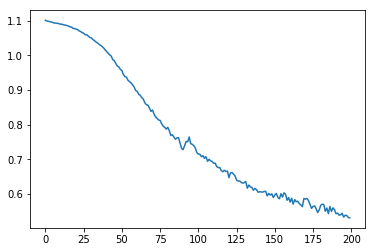

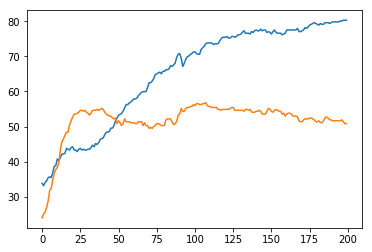

In [11]:
plt.plot(epoch_losses)
plt.show()
plt.plot(np.array(epoch_accuracies).T)
plt.show()

In [13]:
max(epoch_accuracies[1])

56.79347826086956

## Save model and scaler

In [14]:
torch.save(model.state_dict(), "passive_mass_model.pt")

In [15]:
joblib.dump(scaler, "passive_mass_scaler.sk")

['passive_mass_scaler.sk']

## Load model and evaluate

In [16]:
model = ComplexRNNModel(input_dim, first_hidden_dim, second_hidden_dim, output_dim)
model.load_state_dict(torch.load("passive_mass_model.pt"))
model.eval()
model = model.cuda()

In [17]:
accuracy, predicted = evaluate(model, val_loader, return_predicted=True)

In [18]:
print(accuracy)

50.81521739130435


In [19]:
predicted = [pred.cpu() for pred in predicted]
Y_val = np.concatenate([y.cpu().numpy() for x, y in val_loader])

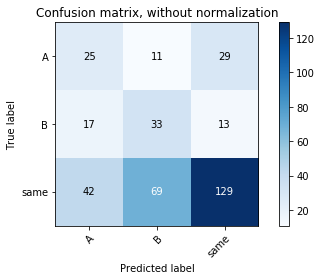

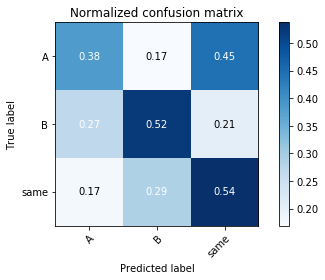

In [20]:
plot_confusion_matrix(Y_val, predicted, classes=MASS_CLASS_COLS, normalize=False)
plot_confusion_matrix(Y_val, predicted, classes=MASS_CLASS_COLS, normalize=True)

# FORCE TRAINING (max so far 53%)

## Read dataset and preprocess it

In [21]:
all_trials = read_dataset("passive_trials.h5")
train_loader, val_loader, scaler = prepare_dataset(all_trials, FORCE_CLASS_COLS, 
                                                   normalise_data=True, batch_size=128, test_size=0.3)

In [22]:
Y = []
for x,y in train_loader:
    
    Y.extend(list(y))

counts = np.unique(Y, return_counts=True)[1]

In [23]:
print("Majority class: ", np.max(counts) / np.sum(counts))

Majority class:  0.3333333333333333


## Define model, loss and optimizer

In [24]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

input_dim = len(BASIC_TRAINING_COLS)    # input dimension
first_hidden_dim = 12  # hidden layer dimension
second_hidden_dim = 6     # number of hidden layers
output_dim = 3   # output dimension

model = ComplexRNNModel(input_dim, first_hidden_dim, second_hidden_dim, output_dim)
model = model.cuda()

error = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train model and plot loss and accuracy

In [25]:
epoch_losses, epoch_accuracies = training_loop(model, optimizer, error, train_loader, val_loader, num_epochs=400)

  0%|          | 1/400 [00:00<04:35,  1.45it/s]

1.1015823185443878 34.12698412698413 35.13513513513514


  0%|          | 2/400 [00:01<04:34,  1.45it/s]

1.0986317694187164 34.72222222222222 35.810810810810814


  1%|          | 3/400 [00:02<04:27,  1.48it/s]

1.0977091193199158 33.92857142857143 36.148648648648646


  1%|          | 4/400 [00:02<04:27,  1.48it/s]

1.0967854261398315 33.92857142857143 36.148648648648646


  1%|▏         | 5/400 [00:03<04:25,  1.48it/s]

1.0972227156162262 34.92063492063492 36.486486486486484


  2%|▏         | 6/400 [00:04<04:27,  1.47it/s]

1.0963620245456696 35.317460317460316 36.486486486486484


  2%|▏         | 7/400 [00:04<04:25,  1.48it/s]

1.0953750610351562 35.51587301587302 36.486486486486484


  2%|▏         | 8/400 [00:05<04:27,  1.47it/s]

1.0930987298488617 35.91269841269841 37.16216216216216


  2%|▏         | 9/400 [00:06<04:25,  1.47it/s]

1.0931084156036377 37.5 37.83783783783784


  2%|▎         | 10/400 [00:06<04:23,  1.48it/s]

1.0926478803157806 37.5 37.5


  3%|▎         | 11/400 [00:07<04:22,  1.48it/s]

1.0920988321304321 38.095238095238095 38.513513513513516


  3%|▎         | 12/400 [00:08<04:21,  1.48it/s]

1.089427798986435 38.69047619047619 38.851351351351354


  3%|▎         | 13/400 [00:08<04:19,  1.49it/s]

1.0891694724559784 39.88095238095238 38.513513513513516


  4%|▎         | 14/400 [00:09<04:18,  1.49it/s]

1.0894084572792053 40.67460317460318 38.851351351351354


  4%|▍         | 15/400 [00:10<04:16,  1.50it/s]

1.0870100855827332 41.07142857142857 40.2027027027027


  4%|▍         | 16/400 [00:10<04:16,  1.50it/s]

1.0869399905204773 41.666666666666664 41.554054054054056


  4%|▍         | 17/400 [00:11<04:18,  1.48it/s]

1.0852244794368744 42.65873015873016 41.891891891891895


  4%|▍         | 18/400 [00:12<04:15,  1.49it/s]

1.0839588344097137 43.84920634920635 42.9054054054054


  5%|▍         | 19/400 [00:12<04:11,  1.52it/s]

1.0830623507499695 45.03968253968254 42.567567567567565


  5%|▌         | 20/400 [00:13<04:12,  1.51it/s]

1.081455647945404 45.03968253968254 42.567567567567565


  5%|▌         | 21/400 [00:14<04:14,  1.49it/s]

1.0786090791225433 45.43650793650794 42.229729729729726


  6%|▌         | 22/400 [00:14<04:13,  1.49it/s]

1.0762482583522797 46.82539682539682 42.229729729729726


  6%|▌         | 23/400 [00:15<04:31,  1.39it/s]

1.0767730474472046 47.22222222222222 41.554054054054056


  6%|▌         | 24/400 [00:16<04:47,  1.31it/s]

1.074297547340393 47.22222222222222 40.87837837837838


  6%|▋         | 25/400 [00:17<05:01,  1.24it/s]

1.0727600753307343 47.023809523809526 40.54054054054054


  6%|▋         | 26/400 [00:18<04:59,  1.25it/s]

1.0683550834655762 47.22222222222222 40.87837837837838


  7%|▋         | 27/400 [00:18<04:46,  1.30it/s]

1.0674484968185425 48.41269841269841 40.54054054054054


  7%|▋         | 28/400 [00:19<04:36,  1.35it/s]

1.0633505880832672 48.611111111111114 40.2027027027027


  7%|▋         | 29/400 [00:20<04:31,  1.37it/s]

1.0612478852272034 48.611111111111114 40.54054054054054


  8%|▊         | 30/400 [00:20<04:30,  1.37it/s]

1.0557115077972412 50.3968253968254 40.2027027027027


  8%|▊         | 31/400 [00:21<04:33,  1.35it/s]

1.0505934953689575 51.19047619047619 40.87837837837838


  8%|▊         | 32/400 [00:22<04:46,  1.29it/s]

1.0495726466178894 50.992063492063494 40.54054054054054


  8%|▊         | 33/400 [00:23<04:54,  1.25it/s]

1.0454667210578918 51.58730158730159 40.87837837837838


  8%|▊         | 34/400 [00:24<04:58,  1.23it/s]

1.0425093472003937 53.37301587301587 41.21621621621622


  9%|▉         | 35/400 [00:25<04:52,  1.25it/s]

1.0340146124362946 53.76984126984127 42.229729729729726


  9%|▉         | 36/400 [00:25<04:44,  1.28it/s]

1.0292324125766754 55.15873015873016 42.9054054054054


  9%|▉         | 37/400 [00:26<04:36,  1.31it/s]

1.0228687524795532 54.96031746031746 42.567567567567565


 10%|▉         | 38/400 [00:27<04:31,  1.33it/s]

1.0197818875312805 55.357142857142854 42.567567567567565


 10%|▉         | 39/400 [00:27<04:29,  1.34it/s]

1.0088626742362976 55.55555555555556 42.567567567567565


 10%|█         | 40/400 [00:28<04:27,  1.35it/s]

1.0060319751501083 55.357142857142854 43.24324324324324


 10%|█         | 41/400 [00:29<04:22,  1.37it/s]

0.999381959438324 56.15079365079365 44.25675675675676


 10%|█         | 42/400 [00:30<04:20,  1.38it/s]

0.9947517961263657 57.142857142857146 44.5945945945946


 11%|█         | 43/400 [00:30<04:18,  1.38it/s]

0.9881677627563477 58.53174603174603 45.270270270270274


 11%|█         | 44/400 [00:31<04:16,  1.39it/s]

0.9807049483060837 58.13492063492063 43.58108108108108


 11%|█▏        | 45/400 [00:32<04:17,  1.38it/s]

0.9737102389335632 58.92857142857143 43.91891891891892


 12%|█▏        | 46/400 [00:33<04:22,  1.35it/s]

0.965407058596611 59.72222222222222 43.58108108108108


 12%|█▏        | 47/400 [00:33<04:15,  1.38it/s]

0.9600912928581238 60.714285714285715 44.5945945945946


 12%|█▏        | 48/400 [00:34<04:09,  1.41it/s]

0.9516052752733231 60.714285714285715 44.25675675675676


 12%|█▏        | 49/400 [00:35<04:09,  1.40it/s]

0.9412146806716919 60.91269841269841 44.932432432432435


 12%|█▎        | 50/400 [00:35<04:02,  1.44it/s]

0.9336476922035217 61.70634920634921 44.5945945945946


 13%|█▎        | 51/400 [00:36<04:02,  1.44it/s]

0.9307934939861298 61.904761904761905 44.5945945945946


 13%|█▎        | 52/400 [00:37<03:57,  1.46it/s]

0.9251631200313568 61.111111111111114 44.932432432432435


 13%|█▎        | 53/400 [00:37<03:57,  1.46it/s]

0.9178128242492676 61.30952380952381 44.932432432432435


 14%|█▎        | 54/400 [00:38<03:55,  1.47it/s]

0.9064908772706985 61.70634920634921 45.608108108108105


 14%|█▍        | 55/400 [00:39<03:52,  1.49it/s]

0.9026153832674026 63.492063492063494 45.608108108108105


 14%|█▍        | 56/400 [00:39<03:49,  1.50it/s]

0.8968798369169235 63.69047619047619 45.608108108108105


 14%|█▍        | 57/400 [00:40<03:49,  1.50it/s]

0.886932298541069 65.07936507936508 45.945945945945944


 14%|█▍        | 58/400 [00:41<03:48,  1.50it/s]

0.885000005364418 65.27777777777777 45.945945945945944


 15%|█▍        | 59/400 [00:41<03:46,  1.50it/s]

0.8785157799720764 66.46825396825396 46.95945945945946


 15%|█▌        | 60/400 [00:42<03:47,  1.50it/s]

0.8681463897228241 66.66666666666667 47.2972972972973


 15%|█▌        | 61/400 [00:43<03:45,  1.50it/s]

0.864899754524231 67.26190476190476 47.972972972972975


 16%|█▌        | 62/400 [00:43<03:44,  1.50it/s]

0.8550155758857727 68.65079365079364 48.648648648648646


 16%|█▌        | 63/400 [00:44<03:45,  1.50it/s]

0.8452979773283005 69.24603174603175 48.986486486486484


 16%|█▌        | 64/400 [00:45<03:41,  1.52it/s]

0.8365568965673447 70.43650793650794 48.986486486486484


 16%|█▋        | 65/400 [00:45<03:36,  1.55it/s]

0.8343232125043869 70.03968253968254 48.986486486486484


 16%|█▋        | 66/400 [00:46<03:42,  1.50it/s]

0.8200807869434357 70.23809523809524 49.32432432432432


 17%|█▋        | 67/400 [00:47<04:02,  1.37it/s]

0.8186445981264114 70.83333333333333 49.66216216216216


 17%|█▋        | 68/400 [00:48<04:05,  1.35it/s]

0.8087601363658905 71.82539682539682 50.33783783783784


 17%|█▋        | 69/400 [00:48<04:17,  1.28it/s]

0.8004767298698425 71.82539682539682 51.013513513513516


 18%|█▊        | 70/400 [00:49<04:13,  1.30it/s]

0.7906182408332825 72.22222222222223 51.351351351351354


 18%|█▊        | 71/400 [00:50<04:16,  1.28it/s]

0.7826111614704132 72.02380952380952 52.027027027027025


 18%|█▊        | 72/400 [00:51<04:04,  1.34it/s]

0.7756294757127762 72.22222222222223 52.36486486486486


 18%|█▊        | 73/400 [00:51<03:55,  1.39it/s]

0.7704400718212128 72.22222222222223 52.7027027027027


 18%|█▊        | 74/400 [00:52<03:50,  1.42it/s]

0.7674689292907715 72.42063492063492 52.36486486486486


 19%|█▉        | 75/400 [00:53<03:44,  1.45it/s]

0.7545192241668701 73.80952380952381 52.7027027027027


 19%|█▉        | 76/400 [00:53<03:41,  1.46it/s]

0.747526079416275 74.2063492063492 52.027027027027025


 19%|█▉        | 77/400 [00:54<03:40,  1.47it/s]

0.746022030711174 75.1984126984127 53.37837837837838


 20%|█▉        | 78/400 [00:55<03:36,  1.49it/s]

0.7394243329763412 75.9920634920635 53.37837837837838


 20%|█▉        | 79/400 [00:55<03:35,  1.49it/s]

0.7306966334581375 76.19047619047619 53.37837837837838


 20%|██        | 80/400 [00:56<03:35,  1.49it/s]

0.7242333590984344 76.58730158730158 53.37837837837838


 20%|██        | 81/400 [00:57<03:32,  1.50it/s]

0.7156908512115479 76.98412698412699 53.71621621621622


 20%|██        | 82/400 [00:57<03:33,  1.49it/s]

0.7078160792589188 76.38888888888889 53.37837837837838


 21%|██        | 83/400 [00:58<03:30,  1.50it/s]

0.6956148892641068 76.19047619047619 53.71621621621622


 21%|██        | 84/400 [00:59<03:29,  1.51it/s]

0.6928352117538452 76.78571428571429 53.37837837837838


 21%|██▏       | 85/400 [00:59<03:30,  1.50it/s]

0.6880293041467667 77.18253968253968 53.37837837837838


 22%|██▏       | 86/400 [01:00<03:30,  1.49it/s]

0.6803406774997711 77.77777777777777 54.391891891891895


 22%|██▏       | 87/400 [01:01<03:30,  1.49it/s]

0.6671551465988159 77.97619047619048 53.71621621621622


 22%|██▏       | 88/400 [01:01<03:30,  1.48it/s]

0.6566913425922394 77.38095238095238 53.37837837837838


 22%|██▏       | 89/400 [01:02<03:30,  1.47it/s]

0.6687778532505035 77.77777777777777 53.04054054054054


 22%|██▎       | 90/400 [01:03<03:29,  1.48it/s]

0.6556959301233292 78.17460317460318 54.054054054054056


 23%|██▎       | 91/400 [01:03<03:30,  1.47it/s]

0.6442178040742874 78.37301587301587 54.729729729729726


 23%|██▎       | 92/400 [01:04<03:27,  1.48it/s]

0.6401212066411972 78.76984126984127 54.729729729729726


 23%|██▎       | 93/400 [01:05<03:27,  1.48it/s]

0.6357502639293671 79.16666666666667 54.729729729729726


 24%|██▎       | 94/400 [01:05<03:29,  1.46it/s]

0.620490238070488 80.35714285714286 55.4054054054054


 24%|██▍       | 95/400 [01:06<03:26,  1.48it/s]

0.6162718683481216 80.35714285714286 55.4054054054054


 24%|██▍       | 96/400 [01:07<03:23,  1.49it/s]

0.6078156977891922 80.55555555555556 55.4054054054054


 24%|██▍       | 97/400 [01:07<03:24,  1.48it/s]

0.6085261777043343 80.55555555555556 54.729729729729726


 24%|██▍       | 98/400 [01:08<03:23,  1.49it/s]

0.609760694205761 80.55555555555556 54.054054054054056


 25%|██▍       | 99/400 [01:09<03:28,  1.45it/s]

0.603382520377636 80.35714285714286 53.71621621621622


 25%|██▌       | 100/400 [01:10<03:29,  1.43it/s]

0.5997471213340759 79.56349206349206 53.71621621621622


 25%|██▌       | 101/400 [01:10<03:24,  1.46it/s]

0.5934552550315857 79.56349206349206 54.054054054054056


 26%|██▌       | 102/400 [01:11<03:23,  1.46it/s]

0.5969751179218292 79.56349206349206 54.054054054054056


 26%|██▌       | 103/400 [01:12<03:25,  1.45it/s]

0.5827898383140564 80.15873015873017 55.067567567567565


 26%|██▌       | 104/400 [01:12<03:25,  1.44it/s]

0.577765092253685 80.35714285714286 55.74324324324324


 26%|██▋       | 105/400 [01:13<03:23,  1.45it/s]

0.5781072378158569 80.95238095238095 56.08108108108108


 26%|██▋       | 106/400 [01:14<03:23,  1.45it/s]

0.5711811408400536 81.15079365079364 55.4054054054054


 27%|██▋       | 107/400 [01:14<03:20,  1.46it/s]

0.5640640184283257 81.94444444444444 56.75675675675676


 27%|██▋       | 108/400 [01:15<03:20,  1.45it/s]

0.5750898793339729 81.54761904761905 56.75675675675676


 27%|██▋       | 109/400 [01:16<03:20,  1.45it/s]

0.5578087270259857 81.94444444444444 56.75675675675676


 28%|██▊       | 110/400 [01:16<03:19,  1.45it/s]

0.5464244112372398 81.74603174603175 56.41891891891892


 28%|██▊       | 111/400 [01:17<03:17,  1.47it/s]

0.5596050173044205 81.34920634920636 56.41891891891892


 28%|██▊       | 112/400 [01:18<03:13,  1.49it/s]

0.5387265309691429 80.95238095238095 56.75675675675676


 28%|██▊       | 113/400 [01:18<03:13,  1.48it/s]

0.5562659576535225 81.74603174603175 57.770270270270274


 28%|██▊       | 114/400 [01:19<03:12,  1.48it/s]

0.5503270700573921 82.14285714285714 57.770270270270274


 29%|██▉       | 115/400 [01:20<03:11,  1.49it/s]

0.5619021579623222 82.34126984126983 58.78378378378378


 29%|██▉       | 116/400 [01:20<03:08,  1.50it/s]

0.5487285479903221 82.34126984126983 58.78378378378378


 29%|██▉       | 117/400 [01:21<03:26,  1.37it/s]

0.5436183139681816 81.94444444444444 58.78378378378378


 30%|██▉       | 118/400 [01:22<03:34,  1.32it/s]

0.5567000806331635 82.53968253968254 59.12162162162162


 30%|██▉       | 119/400 [01:23<03:43,  1.25it/s]

0.5332134291529655 83.13492063492063 59.7972972972973


 30%|███       | 120/400 [01:24<03:42,  1.26it/s]

0.5261840671300888 82.93650793650794 59.12162162162162


 30%|███       | 121/400 [01:25<03:45,  1.24it/s]

0.5297773703932762 83.53174603174604 59.45945945945946


 30%|███       | 122/400 [01:25<03:41,  1.25it/s]

0.5217708647251129 83.73015873015873 60.13513513513514


 31%|███       | 123/400 [01:26<03:41,  1.25it/s]

0.5171428099274635 83.92857142857143 60.13513513513514


 31%|███       | 124/400 [01:27<03:37,  1.27it/s]

0.5158153846859932 84.12698412698413 60.13513513513514


 31%|███▏      | 125/400 [01:28<03:27,  1.33it/s]

0.509282074868679 83.13492063492063 59.7972972972973


 32%|███▏      | 126/400 [01:28<03:17,  1.39it/s]

0.5273449197411537 82.73809523809524 58.78378378378378


 32%|███▏      | 127/400 [01:29<03:13,  1.41it/s]

0.5318399295210838 82.34126984126983 57.770270270270274


 32%|███▏      | 128/400 [01:30<03:12,  1.41it/s]

0.5329862907528877 83.13492063492063 57.770270270270274


 32%|███▏      | 129/400 [01:30<03:11,  1.41it/s]

0.5155342295765877 84.32539682539682 59.12162162162162


 32%|███▎      | 130/400 [01:31<03:09,  1.42it/s]

0.5008719861507416 84.32539682539682 59.7972972972973


 33%|███▎      | 131/400 [01:32<03:07,  1.43it/s]

0.4999290704727173 84.72222222222223 60.13513513513514


 33%|███▎      | 132/400 [01:32<03:07,  1.43it/s]

0.49417687952518463 85.11904761904762 60.810810810810814


 33%|███▎      | 133/400 [01:33<03:06,  1.43it/s]

0.4921237528324127 84.92063492063492 60.810810810810814


 34%|███▎      | 134/400 [01:34<03:04,  1.44it/s]

0.49846457690000534 84.72222222222223 60.13513513513514


 34%|███▍      | 135/400 [01:35<03:01,  1.46it/s]

0.4868355765938759 85.31746031746032 60.13513513513514


 34%|███▍      | 136/400 [01:35<03:01,  1.46it/s]

0.4870700463652611 84.72222222222223 59.45945945945946


 34%|███▍      | 137/400 [01:36<03:00,  1.45it/s]

0.4943599998950958 84.92063492063492 59.45945945945946


 34%|███▍      | 138/400 [01:37<03:00,  1.45it/s]

0.48570679128170013 84.52380952380952 59.45945945945946


 35%|███▍      | 139/400 [01:37<03:00,  1.45it/s]

0.47834860533475876 84.52380952380952 59.12162162162162


 35%|███▌      | 140/400 [01:38<03:02,  1.43it/s]

0.4804350733757019 84.72222222222223 59.45945945945946


 35%|███▌      | 141/400 [01:39<03:13,  1.34it/s]

0.4788438528776169 85.11904761904762 59.12162162162162


 36%|███▌      | 142/400 [01:40<03:15,  1.32it/s]

0.4729374721646309 85.31746031746032 59.45945945945946


 36%|███▌      | 143/400 [01:40<03:16,  1.31it/s]

0.4559740349650383 85.11904761904762 59.45945945945946


 36%|███▌      | 144/400 [01:41<03:11,  1.33it/s]

0.45533815026283264 85.31746031746032 59.7972972972973


 36%|███▋      | 145/400 [01:42<03:06,  1.37it/s]

0.4549068734049797 85.31746031746032 60.13513513513514


 36%|███▋      | 146/400 [01:43<03:01,  1.40it/s]

0.4555684104561806 84.72222222222223 59.45945945945946


 37%|███▋      | 147/400 [01:43<03:00,  1.40it/s]

0.4505835995078087 84.52380952380952 59.12162162162162


 37%|███▋      | 148/400 [01:44<02:57,  1.42it/s]

0.45179661363363266 84.92063492063492 59.7972972972973


 37%|███▋      | 149/400 [01:45<02:55,  1.43it/s]

0.4462132304906845 85.51587301587301 60.13513513513514


 38%|███▊      | 150/400 [01:45<02:54,  1.43it/s]

0.44106558710336685 85.31746031746032 60.472972972972975


 38%|███▊      | 151/400 [01:46<02:55,  1.42it/s]

0.4455944001674652 85.51587301587301 60.472972972972975


 38%|███▊      | 152/400 [01:47<02:53,  1.43it/s]

0.4407558813691139 85.71428571428571 60.472972972972975


 38%|███▊      | 153/400 [01:47<02:52,  1.43it/s]

0.4396448954939842 85.51587301587301 60.810810810810814


 38%|███▊      | 154/400 [01:48<02:50,  1.45it/s]

0.4319160208106041 85.71428571428571 60.472972972972975


 39%|███▉      | 155/400 [01:49<02:50,  1.44it/s]

0.427585206925869 86.11111111111111 60.13513513513514


 39%|███▉      | 156/400 [01:49<02:49,  1.44it/s]

0.4314873591065407 86.11111111111111 60.13513513513514


 39%|███▉      | 157/400 [01:50<02:48,  1.44it/s]

0.4393981397151947 85.91269841269842 60.13513513513514


 40%|███▉      | 158/400 [01:51<02:48,  1.44it/s]

0.43222611397504807 85.91269841269842 60.13513513513514


 40%|███▉      | 159/400 [01:52<02:47,  1.44it/s]

0.43697912991046906 86.11111111111111 60.810810810810814


 40%|████      | 160/400 [01:52<02:47,  1.43it/s]

0.4149671569466591 85.71428571428571 60.472972972972975


 40%|████      | 161/400 [01:53<02:46,  1.44it/s]

0.4207497909665108 85.91269841269842 61.148648648648646


 40%|████      | 162/400 [01:54<02:44,  1.45it/s]

0.4241853281855583 86.11111111111111 61.486486486486484


 41%|████      | 163/400 [01:54<02:42,  1.46it/s]

0.41110900044441223 86.7063492063492 61.148648648648646


 41%|████      | 164/400 [01:55<02:44,  1.44it/s]

0.41627446562051773 86.7063492063492 61.148648648648646


 41%|████▏     | 165/400 [01:56<02:43,  1.43it/s]

0.41613148897886276 86.7063492063492 61.148648648648646


 42%|████▏     | 166/400 [01:56<02:43,  1.43it/s]

0.4140218570828438 86.7063492063492 60.810810810810814


 42%|████▏     | 167/400 [01:57<02:42,  1.43it/s]

0.4119041785597801 86.7063492063492 60.472972972972975


 42%|████▏     | 168/400 [01:58<02:41,  1.44it/s]

0.4090937599539757 86.7063492063492 60.810810810810814


 42%|████▏     | 169/400 [01:59<02:40,  1.44it/s]

0.4042689651250839 86.7063492063492 61.486486486486484


 42%|████▎     | 170/400 [01:59<02:39,  1.44it/s]

0.41439686715602875 86.7063492063492 61.486486486486484


 43%|████▎     | 171/400 [02:00<02:39,  1.44it/s]

0.4054447263479233 86.30952380952381 61.82432432432432


 43%|████▎     | 172/400 [02:01<02:37,  1.44it/s]

0.3978944271802902 86.30952380952381 61.486486486486484


 43%|████▎     | 173/400 [02:01<02:36,  1.45it/s]

0.3981575518846512 85.91269841269842 61.148648648648646


 44%|████▎     | 174/400 [02:02<02:48,  1.34it/s]

0.41074271500110626 86.11111111111111 60.472972972972975


 44%|████▍     | 175/400 [02:03<02:51,  1.31it/s]

0.3923320844769478 86.30952380952381 60.810810810810814


 44%|████▍     | 176/400 [02:04<02:55,  1.28it/s]

0.39456266164779663 86.5079365079365 60.472972972972975


 44%|████▍     | 177/400 [02:05<02:53,  1.28it/s]

0.39332643151283264 86.9047619047619 60.810810810810814


 44%|████▍     | 178/400 [02:05<02:52,  1.29it/s]

0.39853546023368835 87.6984126984127 60.810810810810814


 45%|████▍     | 179/400 [02:06<02:52,  1.28it/s]

0.3927491381764412 87.5 61.148648648648646


 45%|████▌     | 180/400 [02:07<02:45,  1.33it/s]

0.38351382315158844 87.5 60.810810810810814


 45%|████▌     | 181/400 [02:07<02:38,  1.38it/s]

0.3915970101952553 87.6984126984127 60.810810810810814


 46%|████▌     | 182/400 [02:08<02:35,  1.41it/s]

0.39303892850875854 87.6984126984127 60.472972972972975


 46%|████▌     | 183/400 [02:09<02:30,  1.44it/s]

0.3745274171233177 87.5 59.7972972972973


 46%|████▌     | 184/400 [02:09<02:28,  1.45it/s]

0.38081371039152145 87.3015873015873 59.7972972972973


 46%|████▋     | 185/400 [02:10<02:27,  1.45it/s]

0.3937901258468628 87.3015873015873 59.45945945945946


 46%|████▋     | 186/400 [02:11<02:27,  1.45it/s]

0.3878775015473366 87.10317460317461 59.45945945945946


 47%|████▋     | 187/400 [02:12<02:25,  1.46it/s]

0.38878999650478363 87.10317460317461 59.45945945945946


 47%|████▋     | 188/400 [02:12<02:25,  1.45it/s]

0.3847646936774254 87.3015873015873 59.45945945945946


 47%|████▋     | 189/400 [02:13<02:25,  1.45it/s]

0.4031261131167412 86.9047619047619 59.45945945945946


 48%|████▊     | 190/400 [02:14<02:25,  1.45it/s]

0.3885190784931183 86.7063492063492 60.13513513513514


 48%|████▊     | 191/400 [02:14<02:25,  1.44it/s]

0.4035407826304436 86.5079365079365 60.472972972972975


 48%|████▊     | 192/400 [02:15<02:23,  1.45it/s]

0.4073239341378212 85.91269841269842 59.12162162162162


 48%|████▊     | 193/400 [02:16<02:23,  1.44it/s]

0.42821476608514786 86.7063492063492 59.12162162162162


 48%|████▊     | 194/400 [02:16<02:23,  1.43it/s]

0.39891406148672104 86.5079365079365 59.12162162162162


 49%|████▉     | 195/400 [02:17<02:22,  1.44it/s]

0.4091940224170685 86.9047619047619 59.45945945945946


 49%|████▉     | 196/400 [02:18<02:22,  1.43it/s]

0.3951762244105339 87.3015873015873 59.12162162162162


 49%|████▉     | 197/400 [02:18<02:21,  1.44it/s]

0.39558060467243195 86.7063492063492 58.445945945945944


 50%|████▉     | 198/400 [02:19<02:21,  1.43it/s]

0.38601967692375183 86.9047619047619 58.445945945945944


 50%|████▉     | 199/400 [02:20<02:19,  1.45it/s]

0.3977437987923622 87.10317460317461 58.108108108108105


 50%|█████     | 200/400 [02:21<02:19,  1.44it/s]

0.3850507214665413 87.10317460317461 58.445945945945944


 50%|█████     | 201/400 [02:21<02:19,  1.43it/s]

0.37707219272851944 87.3015873015873 58.108108108108105


 50%|█████     | 202/400 [02:22<02:17,  1.44it/s]

0.389077328145504 87.10317460317461 58.78378378378378


 51%|█████     | 203/400 [02:23<02:16,  1.45it/s]

0.3795757070183754 87.3015873015873 58.78378378378378


 51%|█████     | 204/400 [02:23<02:14,  1.46it/s]

0.36896222084760666 87.5 58.445945945945944


 51%|█████▏    | 205/400 [02:24<02:16,  1.43it/s]

0.3841494843363762 87.3015873015873 58.78378378378378


 52%|█████▏    | 206/400 [02:25<02:20,  1.38it/s]

0.3713857978582382 87.10317460317461 58.108108108108105


 52%|█████▏    | 207/400 [02:26<02:20,  1.38it/s]

0.36650794744491577 87.3015873015873 58.445945945945944


 52%|█████▏    | 208/400 [02:26<02:28,  1.30it/s]

0.36382992565631866 87.3015873015873 58.445945945945944


 52%|█████▏    | 209/400 [02:27<02:26,  1.31it/s]

0.36372266709804535 87.3015873015873 58.445945945945944


 52%|█████▎    | 210/400 [02:28<02:23,  1.33it/s]

0.3608470782637596 87.3015873015873 58.108108108108105


 53%|█████▎    | 211/400 [02:29<02:20,  1.35it/s]

0.3697245195508003 87.10317460317461 58.445945945945944


 53%|█████▎    | 212/400 [02:29<02:16,  1.38it/s]

0.3568752780556679 87.3015873015873 58.78378378378378


 53%|█████▎    | 213/400 [02:30<02:15,  1.39it/s]

0.3624115660786629 87.5 59.45945945945946


 54%|█████▎    | 214/400 [02:31<02:15,  1.37it/s]

0.36872806400060654 87.6984126984127 59.12162162162162


 54%|█████▍    | 215/400 [02:31<02:13,  1.38it/s]

0.3568296507000923 87.89682539682539 59.12162162162162


 54%|█████▍    | 216/400 [02:32<02:12,  1.39it/s]

0.35698023438453674 88.0952380952381 58.108108108108105


 54%|█████▍    | 217/400 [02:33<02:12,  1.38it/s]

0.3591781184077263 87.89682539682539 58.445945945945944


 55%|█████▍    | 218/400 [02:34<02:09,  1.40it/s]

0.34869448840618134 87.89682539682539 58.445945945945944


 55%|█████▍    | 219/400 [02:34<02:07,  1.42it/s]

0.35568468272686005 88.0952380952381 58.78378378378378


 55%|█████▌    | 220/400 [02:35<02:09,  1.39it/s]

0.3465959057211876 88.4920634920635 59.45945945945946


 55%|█████▌    | 221/400 [02:36<02:08,  1.40it/s]

0.351967990398407 88.4920634920635 59.12162162162162


 56%|█████▌    | 222/400 [02:36<02:07,  1.40it/s]

0.3586934581398964 88.4920634920635 59.12162162162162


 56%|█████▌    | 223/400 [02:37<02:04,  1.42it/s]

0.3414495512843132 88.0952380952381 58.445945945945944


 56%|█████▌    | 224/400 [02:38<02:04,  1.41it/s]

0.3618401736021042 87.5 58.445945945945944


 56%|█████▋    | 225/400 [02:39<02:04,  1.41it/s]

0.3466365709900856 87.89682539682539 59.45945945945946


 56%|█████▋    | 226/400 [02:39<02:03,  1.41it/s]

0.3580176308751106 88.0952380952381 59.45945945945946


 57%|█████▋    | 227/400 [02:40<02:02,  1.41it/s]

0.35908930748701096 88.0952380952381 59.7972972972973


 57%|█████▋    | 228/400 [02:41<02:02,  1.41it/s]

0.3603813052177429 87.89682539682539 58.78378378378378


 57%|█████▋    | 229/400 [02:42<02:06,  1.35it/s]

0.3514368608593941 87.89682539682539 58.108108108108105


 57%|█████▊    | 230/400 [02:42<02:10,  1.31it/s]

0.3587014749646187 86.7063492063492 57.770270270270274


 58%|█████▊    | 231/400 [02:43<02:11,  1.29it/s]

0.40418365597724915 83.53174603174604 57.770270270270274


 58%|█████▊    | 232/400 [02:44<02:10,  1.29it/s]

0.46636369079351425 82.34126984126983 57.0945945945946


 58%|█████▊    | 233/400 [02:45<02:13,  1.25it/s]

0.49954432994127274 80.95238095238095 56.75675675675676


 58%|█████▊    | 234/400 [02:46<02:09,  1.28it/s]

0.5381691977381706 81.34920634920636 57.432432432432435


 59%|█████▉    | 235/400 [02:46<02:07,  1.30it/s]

0.5350590497255325 81.54761904761905 55.74324324324324


 59%|█████▉    | 236/400 [02:47<02:07,  1.29it/s]

0.5152170732617378 81.34920634920636 56.08108108108108


 59%|█████▉    | 237/400 [02:48<02:08,  1.27it/s]

0.5116051957011223 82.53968253968254 56.75675675675676


 60%|█████▉    | 238/400 [02:49<02:10,  1.24it/s]

0.4977724850177765 82.73809523809524 56.75675675675676


 60%|█████▉    | 239/400 [02:50<02:11,  1.23it/s]

0.47904955595731735 83.53174603174604 57.0945945945946


 60%|██████    | 240/400 [02:50<02:09,  1.23it/s]

0.4659915566444397 83.53174603174604 57.432432432432435


 60%|██████    | 241/400 [02:51<02:08,  1.24it/s]

0.4682098478078842 83.53174603174604 57.432432432432435


 60%|██████    | 242/400 [02:52<02:01,  1.30it/s]

0.4547043591737747 83.92857142857143 58.108108108108105


 61%|██████    | 243/400 [02:52<01:56,  1.35it/s]

0.4357191100716591 84.52380952380952 57.432432432432435


 61%|██████    | 244/400 [02:53<01:50,  1.41it/s]

0.4434279352426529 84.72222222222223 56.41891891891892


 61%|██████▏   | 245/400 [02:54<01:48,  1.42it/s]

0.456779420375824 85.51587301587301 56.75675675675676


 62%|██████▏   | 246/400 [02:55<01:48,  1.42it/s]

0.4592312201857567 85.51587301587301 56.75675675675676


 62%|██████▏   | 247/400 [02:55<01:46,  1.44it/s]

0.4286430701613426 85.91269841269842 57.0945945945946


 62%|██████▏   | 248/400 [02:56<01:44,  1.45it/s]

0.4173983335494995 86.30952380952381 58.108108108108105


 62%|██████▏   | 249/400 [02:57<01:42,  1.47it/s]

0.4120957925915718 86.30952380952381 57.770270270270274


 62%|██████▎   | 250/400 [02:57<01:39,  1.50it/s]

0.4130904898047447 86.30952380952381 57.770270270270274


 63%|██████▎   | 251/400 [02:58<01:37,  1.52it/s]

0.39890074729919434 86.5079365079365 58.108108108108105


 63%|██████▎   | 252/400 [02:59<01:40,  1.47it/s]

0.3968818113207817 86.5079365079365 58.108108108108105


 63%|██████▎   | 253/400 [02:59<01:44,  1.41it/s]

0.39945198595523834 86.5079365079365 58.78378378378378


 64%|██████▎   | 254/400 [03:00<01:47,  1.36it/s]

0.3922048434615135 86.30952380952381 58.78378378378378


 64%|██████▍   | 255/400 [03:01<01:54,  1.27it/s]

0.3857693672180176 86.30952380952381 58.78378378378378


 64%|██████▍   | 256/400 [03:02<01:57,  1.22it/s]

0.395607054233551 86.7063492063492 59.12162162162162


 64%|██████▍   | 257/400 [03:03<01:53,  1.26it/s]

0.38644930720329285 86.7063492063492 58.78378378378378


 64%|██████▍   | 258/400 [03:03<01:47,  1.32it/s]

0.39347053319215775 86.9047619047619 58.445945945945944


 65%|██████▍   | 259/400 [03:04<01:41,  1.39it/s]

0.3874307721853256 86.9047619047619 58.445945945945944


 65%|██████▌   | 260/400 [03:05<01:42,  1.37it/s]

0.37830954790115356 86.7063492063492 58.445945945945944


 65%|██████▌   | 261/400 [03:06<01:45,  1.32it/s]

0.38334590196609497 87.3015873015873 59.12162162162162


 66%|██████▌   | 262/400 [03:06<01:45,  1.30it/s]

0.3703942745923996 87.3015873015873 59.45945945945946


 66%|██████▌   | 263/400 [03:07<01:42,  1.34it/s]

0.381367526948452 87.3015873015873 59.45945945945946


 66%|██████▌   | 264/400 [03:08<01:38,  1.39it/s]

0.3828084319829941 87.5 59.45945945945946


 66%|██████▋   | 265/400 [03:08<01:38,  1.37it/s]

0.3696969822049141 87.5 59.45945945945946


 66%|██████▋   | 266/400 [03:09<01:37,  1.37it/s]

0.38014210015535355 87.5 59.45945945945946


 67%|██████▋   | 267/400 [03:10<01:34,  1.41it/s]

0.3751842677593231 87.6984126984127 59.45945945945946


 67%|██████▋   | 268/400 [03:11<01:36,  1.37it/s]

0.3819493278861046 87.5 59.45945945945946


 67%|██████▋   | 269/400 [03:11<01:39,  1.32it/s]

0.37214118987321854 87.3015873015873 59.45945945945946


 68%|██████▊   | 270/400 [03:12<01:38,  1.32it/s]

0.3820262923836708 87.5 59.45945945945946


 68%|██████▊   | 271/400 [03:13<01:38,  1.32it/s]

0.36524663865566254 87.6984126984127 59.45945945945946


 68%|██████▊   | 272/400 [03:14<01:40,  1.28it/s]

0.37154411524534225 87.5 59.45945945945946


 68%|██████▊   | 273/400 [03:15<01:38,  1.28it/s]

0.3590245619416237 87.5 59.45945945945946


 68%|██████▊   | 274/400 [03:15<01:38,  1.27it/s]

0.37061288207769394 87.5 59.45945945945946


 69%|██████▉   | 275/400 [03:16<01:33,  1.34it/s]

0.35277122259140015 87.5 59.45945945945946


 69%|██████▉   | 276/400 [03:17<01:28,  1.40it/s]

0.3647959977388382 87.5 59.45945945945946


 69%|██████▉   | 277/400 [03:17<01:25,  1.43it/s]

0.35673249512910843 87.5 59.12162162162162


 70%|██████▉   | 278/400 [03:18<01:25,  1.43it/s]

0.35718776285648346 87.5 59.12162162162162


 70%|██████▉   | 279/400 [03:19<01:24,  1.43it/s]

0.3638981878757477 87.5 59.12162162162162


 70%|███████   | 280/400 [03:19<01:21,  1.47it/s]

0.3795103654265404 87.5 59.12162162162162


 70%|███████   | 281/400 [03:20<01:19,  1.49it/s]

0.34669750928878784 87.6984126984127 59.12162162162162


 70%|███████   | 282/400 [03:21<01:17,  1.52it/s]

0.3564732223749161 87.6984126984127 59.45945945945946


 71%|███████   | 283/400 [03:21<01:17,  1.52it/s]

0.35532546788454056 87.6984126984127 59.7972972972973


 71%|███████   | 284/400 [03:22<01:15,  1.53it/s]

0.3517874926328659 88.0952380952381 60.13513513513514


 71%|███████▏  | 285/400 [03:23<01:14,  1.54it/s]

0.3588247075676918 88.2936507936508 60.13513513513514


 72%|███████▏  | 286/400 [03:23<01:13,  1.55it/s]

0.3514693155884743 88.0952380952381 60.13513513513514


 72%|███████▏  | 287/400 [03:24<01:15,  1.49it/s]

0.34904809296131134 88.0952380952381 60.13513513513514


 72%|███████▏  | 288/400 [03:25<01:18,  1.43it/s]

0.346972718834877 88.0952380952381 60.13513513513514


 72%|███████▏  | 289/400 [03:25<01:20,  1.38it/s]

0.35500266402959824 88.0952380952381 60.13513513513514


 72%|███████▎  | 290/400 [03:26<01:21,  1.36it/s]

0.3419651910662651 88.0952380952381 60.13513513513514


 73%|███████▎  | 291/400 [03:27<01:21,  1.34it/s]

0.3467741757631302 87.89682539682539 60.13513513513514


 73%|███████▎  | 292/400 [03:28<01:22,  1.31it/s]

0.35243648290634155 87.89682539682539 60.810810810810814


 73%|███████▎  | 293/400 [03:29<01:21,  1.31it/s]

0.3447389379143715 87.89682539682539 60.810810810810814


 74%|███████▎  | 294/400 [03:29<01:22,  1.29it/s]

0.34620773047208786 88.0952380952381 60.472972972972975


 74%|███████▍  | 295/400 [03:30<01:21,  1.29it/s]

0.3372746407985687 88.2936507936508 61.148648648648646


 74%|███████▍  | 296/400 [03:31<01:21,  1.28it/s]

0.34103985875844955 88.2936507936508 60.472972972972975


 74%|███████▍  | 297/400 [03:32<01:22,  1.26it/s]

0.3388396054506302 88.2936507936508 60.472972972972975


 74%|███████▍  | 298/400 [03:33<01:22,  1.23it/s]

0.3490906283259392 88.4920634920635 60.810810810810814


 75%|███████▍  | 299/400 [03:33<01:22,  1.22it/s]

0.33693429082632065 88.2936507936508 60.810810810810814


 75%|███████▌  | 300/400 [03:34<01:21,  1.22it/s]

0.3321639746427536 88.4920634920635 60.810810810810814


 75%|███████▌  | 301/400 [03:35<01:20,  1.23it/s]

0.3345693498849869 88.4920634920635 60.810810810810814


 76%|███████▌  | 302/400 [03:36<01:20,  1.22it/s]

0.33646319061517715 88.4920634920635 60.810810810810814


 76%|███████▌  | 303/400 [03:37<01:19,  1.22it/s]

0.3395272120833397 88.4920634920635 60.810810810810814


 76%|███████▌  | 304/400 [03:38<01:19,  1.21it/s]

0.32682614773511887 88.2936507936508 60.472972972972975


 76%|███████▋  | 305/400 [03:38<01:18,  1.22it/s]

0.34852947294712067 88.4920634920635 60.472972972972975


 76%|███████▋  | 306/400 [03:39<01:14,  1.25it/s]

0.32730138301849365 88.4920634920635 60.472972972972975


 77%|███████▋  | 307/400 [03:40<01:13,  1.27it/s]

0.3418598771095276 88.69047619047619 60.810810810810814


 77%|███████▋  | 308/400 [03:41<01:08,  1.34it/s]

0.3365037143230438 88.0952380952381 60.13513513513514


 77%|███████▋  | 309/400 [03:41<01:06,  1.37it/s]

0.3346078470349312 88.0952380952381 60.472972972972975


 78%|███████▊  | 310/400 [03:42<01:03,  1.42it/s]

0.3384172394871712 88.2936507936508 60.472972972972975


 78%|███████▊  | 311/400 [03:43<01:01,  1.44it/s]

0.3382974937558174 88.0952380952381 58.78378378378378


 78%|███████▊  | 312/400 [03:43<00:59,  1.47it/s]

0.33637218177318573 88.2936507936508 59.12162162162162


 78%|███████▊  | 313/400 [03:44<00:58,  1.49it/s]

0.3459431901574135 88.0952380952381 57.432432432432435


 78%|███████▊  | 314/400 [03:45<00:59,  1.44it/s]

0.34616275131702423 88.0952380952381 57.0945945945946


 79%|███████▉  | 315/400 [03:45<00:59,  1.43it/s]

0.3399941399693489 87.89682539682539 57.770270270270274


 79%|███████▉  | 316/400 [03:46<00:59,  1.40it/s]

0.3511848822236061 87.89682539682539 58.108108108108105


 79%|███████▉  | 317/400 [03:47<00:59,  1.39it/s]

0.3543979227542877 88.4920634920635 58.78378378378378


 80%|███████▉  | 318/400 [03:48<01:02,  1.32it/s]

0.33841828256845474 88.4920634920635 58.78378378378378


 80%|███████▉  | 319/400 [03:48<01:01,  1.31it/s]

0.33090439438819885 88.4920634920635 58.78378378378378


 80%|████████  | 320/400 [03:49<00:59,  1.34it/s]

0.3395637795329094 88.69047619047619 59.45945945945946


 80%|████████  | 321/400 [03:50<00:58,  1.35it/s]

0.32565370202064514 88.4920634920635 60.13513513513514


 80%|████████  | 322/400 [03:51<00:57,  1.36it/s]

0.3319757282733917 88.88888888888889 60.13513513513514


 81%|████████  | 323/400 [03:51<00:56,  1.37it/s]

0.33500248193740845 88.88888888888889 60.13513513513514


 81%|████████  | 324/400 [03:52<00:54,  1.39it/s]

0.31320907920598984 88.88888888888889 60.13513513513514


 81%|████████▏ | 325/400 [03:53<00:52,  1.42it/s]

0.320895791053772 88.88888888888889 60.13513513513514


 82%|████████▏ | 326/400 [03:53<00:52,  1.42it/s]

0.3181215077638626 88.88888888888889 60.13513513513514


 82%|████████▏ | 327/400 [03:54<00:50,  1.44it/s]

0.32292910665273666 89.08730158730158 60.13513513513514


 82%|████████▏ | 328/400 [03:55<00:49,  1.44it/s]

0.31936950981616974 89.08730158730158 60.13513513513514


 82%|████████▏ | 329/400 [03:55<00:50,  1.41it/s]

0.31815943121910095 89.08730158730158 60.13513513513514


 82%|████████▎ | 330/400 [03:56<00:49,  1.41it/s]

0.3161293938755989 89.08730158730158 60.13513513513514


 83%|████████▎ | 331/400 [03:57<00:49,  1.40it/s]

0.30378030240535736 89.08730158730158 60.13513513513514


 83%|████████▎ | 332/400 [03:58<00:48,  1.41it/s]

0.31203241646289825 89.28571428571429 60.472972972972975


 83%|████████▎ | 333/400 [03:58<00:47,  1.41it/s]

0.3143535181879997 89.28571428571429 60.472972972972975


 84%|████████▎ | 334/400 [03:59<00:46,  1.42it/s]

0.31141965091228485 89.28571428571429 60.13513513513514


 84%|████████▍ | 335/400 [04:00<00:45,  1.43it/s]

0.3092156648635864 89.28571428571429 60.472972972972975


 84%|████████▍ | 336/400 [04:00<00:44,  1.44it/s]

0.30713531374931335 89.28571428571429 60.810810810810814


 84%|████████▍ | 337/400 [04:01<00:43,  1.45it/s]

0.3083640858530998 89.08730158730158 60.810810810810814


 84%|████████▍ | 338/400 [04:02<00:42,  1.44it/s]

0.3025849983096123 89.08730158730158 60.810810810810814


 85%|████████▍ | 339/400 [04:02<00:42,  1.44it/s]

0.30064528435468674 89.08730158730158 60.810810810810814


 85%|████████▌ | 340/400 [04:03<00:42,  1.41it/s]

0.3092018663883209 89.28571428571429 60.810810810810814


 85%|████████▌ | 341/400 [04:04<00:41,  1.42it/s]

0.3144766390323639 89.28571428571429 60.810810810810814


 86%|████████▌ | 342/400 [04:05<00:41,  1.41it/s]

0.31300561875104904 89.48412698412699 60.472972972972975


 86%|████████▌ | 343/400 [04:05<00:42,  1.34it/s]

0.29852842539548874 89.88095238095238 60.472972972972975


 86%|████████▌ | 344/400 [04:06<00:42,  1.33it/s]

0.3026147112250328 89.88095238095238 60.472972972972975


 86%|████████▋ | 345/400 [04:07<00:41,  1.31it/s]

0.3079080283641815 89.88095238095238 60.472972972972975


 86%|████████▋ | 346/400 [04:08<00:40,  1.32it/s]

0.29799868911504745 89.88095238095238 60.810810810810814


 87%|████████▋ | 347/400 [04:08<00:39,  1.34it/s]

0.29553522914648056 89.88095238095238 60.810810810810814


 87%|████████▋ | 348/400 [04:09<00:39,  1.31it/s]

0.29848218709230423 89.88095238095238 60.810810810810814


 87%|████████▋ | 349/400 [04:10<00:39,  1.31it/s]

0.30282261222600937 89.88095238095238 60.810810810810814


 88%|████████▊ | 350/400 [04:11<00:39,  1.28it/s]

0.29097621887922287 89.68253968253968 60.810810810810814


 88%|████████▊ | 351/400 [04:12<00:37,  1.30it/s]

0.28757593780755997 89.68253968253968 60.810810810810814


 88%|████████▊ | 352/400 [04:12<00:36,  1.30it/s]

0.3071671798825264 89.68253968253968 60.810810810810814


 88%|████████▊ | 353/400 [04:13<00:35,  1.34it/s]

0.29458265006542206 89.68253968253968 60.472972972972975


 88%|████████▊ | 354/400 [04:14<00:34,  1.32it/s]

0.3004463016986847 89.68253968253968 60.472972972972975


 89%|████████▉ | 355/400 [04:15<00:34,  1.30it/s]

0.3020871505141258 89.68253968253968 60.472972972972975


 89%|████████▉ | 356/400 [04:15<00:34,  1.29it/s]

0.2977540045976639 89.68253968253968 60.472972972972975


 89%|████████▉ | 357/400 [04:16<00:34,  1.26it/s]

0.2919672802090645 89.88095238095238 60.472972972972975


 90%|████████▉ | 358/400 [04:17<00:33,  1.26it/s]

0.30029983818531036 89.88095238095238 60.810810810810814


 90%|████████▉ | 359/400 [04:18<00:32,  1.26it/s]

0.2951948121190071 89.68253968253968 60.472972972972975


 90%|█████████ | 360/400 [04:19<00:31,  1.26it/s]

0.2864411473274231 89.68253968253968 60.472972972972975


 90%|█████████ | 361/400 [04:20<00:31,  1.22it/s]

0.293642558157444 89.48412698412699 60.13513513513514


 90%|█████████ | 362/400 [04:20<00:31,  1.22it/s]

0.2986603081226349 89.48412698412699 60.13513513513514


 91%|█████████ | 363/400 [04:21<00:29,  1.27it/s]

0.29375434666872025 89.28571428571429 60.472972972972975


 91%|█████████ | 364/400 [04:22<00:28,  1.25it/s]

0.3000449538230896 89.28571428571429 60.472972972972975


 91%|█████████▏| 365/400 [04:23<00:27,  1.27it/s]

0.30531416833400726 89.08730158730158 60.472972972972975


 92%|█████████▏| 366/400 [04:24<00:27,  1.22it/s]

0.3042016699910164 89.28571428571429 60.472972972972975


 92%|█████████▏| 367/400 [04:24<00:27,  1.19it/s]

0.31206871569156647 90.27777777777777 61.486486486486484


 92%|█████████▏| 368/400 [04:25<00:26,  1.19it/s]

0.28297659754753113 89.48412698412699 60.472972972972975


 92%|█████████▏| 369/400 [04:26<00:25,  1.20it/s]

0.3237040266394615 88.69047619047619 59.12162162162162


 92%|█████████▎| 370/400 [04:27<00:23,  1.26it/s]

0.32843104749917984 88.69047619047619 58.78378378378378


 93%|█████████▎| 371/400 [04:27<00:21,  1.33it/s]

0.31218546628952026 89.28571428571429 59.12162162162162


 93%|█████████▎| 372/400 [04:28<00:20,  1.37it/s]

0.32108697295188904 89.48412698412699 58.445945945945944


 93%|█████████▎| 373/400 [04:29<00:19,  1.41it/s]

0.30159052461385727 89.68253968253968 58.445945945945944


 94%|█████████▎| 374/400 [04:29<00:18,  1.43it/s]

0.31347645819187164 89.48412698412699 58.78378378378378


 94%|█████████▍| 375/400 [04:30<00:17,  1.43it/s]

0.3025200590491295 89.28571428571429 58.445945945945944


 94%|█████████▍| 376/400 [04:31<00:17,  1.39it/s]

0.3035196512937546 89.28571428571429 58.445945945945944


 94%|█████████▍| 377/400 [04:32<00:17,  1.30it/s]

0.2983122318983078 89.48412698412699 59.12162162162162


 94%|█████████▍| 378/400 [04:33<00:17,  1.24it/s]

0.3033381253480911 89.68253968253968 59.45945945945946


 95%|█████████▍| 379/400 [04:34<00:17,  1.21it/s]

0.3029584661126137 89.68253968253968 59.45945945945946


 95%|█████████▌| 380/400 [04:34<00:16,  1.18it/s]

0.29360439628362656 89.28571428571429 59.45945945945946


 95%|█████████▌| 381/400 [04:35<00:16,  1.16it/s]

0.286026768386364 89.28571428571429 59.12162162162162


 96%|█████████▌| 382/400 [04:36<00:15,  1.17it/s]

0.2969648689031601 89.08730158730158 59.12162162162162


 96%|█████████▌| 383/400 [04:37<00:14,  1.16it/s]

0.2862211689352989 89.28571428571429 59.12162162162162


 96%|█████████▌| 384/400 [04:38<00:13,  1.15it/s]

0.2989629656076431 89.28571428571429 59.12162162162162


 96%|█████████▋| 385/400 [04:39<00:12,  1.19it/s]

0.29274728894233704 89.48412698412699 59.45945945945946


 96%|█████████▋| 386/400 [04:40<00:11,  1.18it/s]

0.2945023402571678 89.48412698412699 59.45945945945946


 97%|█████████▋| 387/400 [04:40<00:10,  1.19it/s]

0.2838347963988781 89.88095238095238 59.45945945945946


 97%|█████████▋| 388/400 [04:41<00:09,  1.23it/s]

0.28565970808267593 90.27777777777777 59.7972972972973


 97%|█████████▋| 389/400 [04:42<00:09,  1.21it/s]

0.2780720740556717 90.27777777777777 59.7972972972973


 98%|█████████▊| 390/400 [04:43<00:08,  1.22it/s]

0.2859133630990982 90.67460317460318 60.472972972972975


 98%|█████████▊| 391/400 [04:44<00:07,  1.26it/s]

0.27426960691809654 90.67460317460318 60.472972972972975


 98%|█████████▊| 392/400 [04:44<00:06,  1.29it/s]

0.28238437697291374 90.67460317460318 60.472972972972975


 98%|█████████▊| 393/400 [04:45<00:05,  1.24it/s]

0.28603900223970413 90.67460317460318 60.472972972972975


 98%|█████████▊| 394/400 [04:46<00:04,  1.21it/s]

0.28464213758707047 90.67460317460318 60.472972972972975


 99%|█████████▉| 395/400 [04:47<00:04,  1.20it/s]

0.28173820674419403 90.67460317460318 60.472972972972975


 99%|█████████▉| 396/400 [04:48<00:03,  1.20it/s]

0.27504177391529083 90.47619047619048 60.472972972972975


 99%|█████████▉| 397/400 [04:49<00:02,  1.20it/s]

0.27872247248888016 90.27777777777777 60.472972972972975


100%|█████████▉| 398/400 [04:49<00:01,  1.24it/s]

0.2870657593011856 90.47619047619048 60.472972972972975


100%|█████████▉| 399/400 [04:50<00:00,  1.25it/s]

0.2953159064054489 90.67460317460318 60.810810810810814


100%|██████████| 400/400 [04:51<00:00,  1.25it/s]

0.28279079496860504 90.67460317460318 60.810810810810814


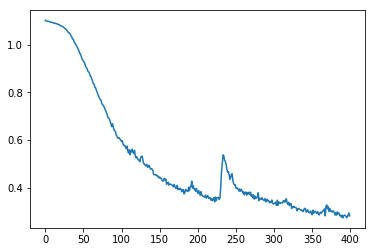

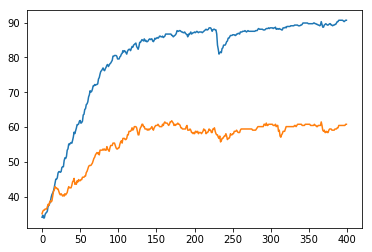

In [27]:
plt.plot(epoch_losses)
plt.show()
plt.plot(np.array(epoch_accuracies).T)
plt.show()

In [29]:
max(epoch_accuracies[1])

61.82432432432432

## Save model and scaler

In [30]:
torch.save(model.state_dict(), "passive_force_model.pt")

In [31]:
joblib.dump(scaler, "passive_force_scaler.sk")

['passive_force_scaler.sk']

## Load model and evaluate

In [32]:
model = ComplexRNNModel(input_dim, first_hidden_dim, second_hidden_dim, output_dim)
model.load_state_dict(torch.load("passive_force_model.pt"))
model.eval()
model = model.cuda()

In [33]:
accuracy, predicted = evaluate(model, val_loader, return_predicted=True)

In [34]:
print(accuracy)

60.810810810810814


In [35]:
predicted = [pred.cpu() for pred in predicted]
Y_val = np.concatenate([y.cpu().numpy() for x, y in val_loader])

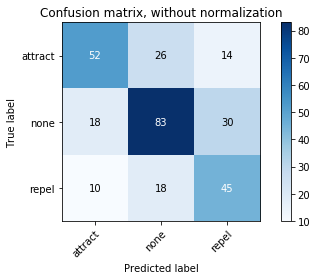

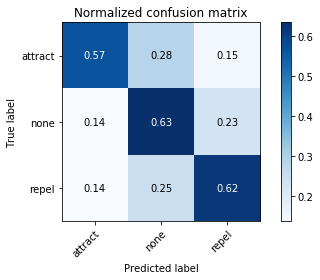

In [36]:
plot_confusion_matrix(Y_val, predicted, classes=FORCE_CLASS_COLS, normalize=False)
plot_confusion_matrix(Y_val, predicted, classes=FORCE_CLASS_COLS, normalize=True)